In [48]:
"""
-*- coding: utf-8 -*- Created on Fri 21 2020
@author: Thiago Pinho
@colaborators: Thiago Russo, Emmanuel Perotto
"""


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import LatentDirichletAllocation as LDA
import spacy
from spacy.lang.pt import Portuguese
from spacy.lang.pt.stop_words import STOP_WORDS
from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from string import punctuation
from tqdm.notebook import tqdm
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import warnings
from preprocessing import generate_freq_dist_plot, generate_wordcloud
warnings.simplefilter("ignore", DeprecationWarning)

## Constants
For better code management, the constants used in this notebook will be listed bellow.

In [2]:
VECTOR_MODEL_NAME = "pt_core_news_sm"
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/ribon/"
DATA_FILENAME = "feeds_label"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
TARGET_VARIABLE = "LABEL_TRAIN"
POSSIBLE_TEXT_VARIABLES = ["CONTENT", "TITLE"]

## Load raw data and start to treat the it's structure
We'll have a first look at the raw data and after analysing it's structure we can fix missing values(By dropping or artificially inserting then). We can encode or adjust categorical data if needed, fix column names and also drop unnused colummns.

In [3]:
"""  load the dataset """
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".csv"
df_ribon_news = pd.read_csv(relative_path_file)
print(df_ribon_news.info())
print()
print(df_ribon_news['Label_Train'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           888 non-null    int64 
 1   pick_count   888 non-null    int64 
 2   content      886 non-null    object
 3   title        888 non-null    object
 4   Label_Train  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.8+ KB
None

['Animais' 'Solidariedade' 'Familia' 'Criancas' 'Proposito' 'Diversidade'
 'Educacao' 'Ecologia' 'Saude' 'Idosos' 'Ciencia' 'Celebracao' 'Etnias'
 'Esporte' 'Cultura' 'proposito' 'Empreendedorismo' 'empreendedorismo'
 'solidariedade' 'diversidade' 'celebracao' 'ecologia' 'etnias' 'ciencia'
 'saude' 'cultura' 'educacao' 'criancas']


### Results
Based on the previous step it's possible to notice two things:

1) First is that the column labels are not all uppercase or lowercase. 

2) The categories avaiable to classify are not all in the same case either which could lead to later confunsion on the real number of categories the model should classify.

So we will fix by making: 

1) All **column names** will be **uppercase**

2) All **target categories** will also be **uppercase**

In [4]:
"""  Preprocessing the dataset names and values """
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
""" Converting all labels in TARGET_VARIABLE to uppercase """
df_ribon_news[TARGET_VARIABLE] = df_ribon_news[TARGET_VARIABLE].str.upper()
print("Column names are now: ", df_ribon_news.columns.to_list())
print()
print(TARGET_VARIABLE + " categories are now: ", df_ribon_news[TARGET_VARIABLE].unique())

Column names are now:  ['ID', 'PICK_COUNT', 'CONTENT', 'TITLE', 'LABEL_TRAIN']

LABEL_TRAIN categories are now:  ['ANIMAIS' 'SOLIDARIEDADE' 'FAMILIA' 'CRIANCAS' 'PROPOSITO' 'DIVERSIDADE'
 'EDUCACAO' 'ECOLOGIA' 'SAUDE' 'IDOSOS' 'CIENCIA' 'CELEBRACAO' 'ETNIAS'
 'ESPORTE' 'CULTURA' 'EMPREENDEDORISMO']


### Storing partial progress
One of the advantages of jupyter notebook is the possibility of only repeating parts of the code when there is need for it. So let's store our partial progress for more stability and less rework.

In [5]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + "_treated.xlsx"

In [6]:
"""  Convert the dataframe to an xlsx file """
df_ribon_news.to_excel(excel_filename)

print("Stored tread dataset on ", excel_filename)

Stored tread dataset on  ./assets/datasets/ribon/feeds_label_treated.xlsx


## Load and analyse treated data
Now we have treated some structural characteristics of the data and some details, let's analyse the data.

In [7]:
"""  Load the data for stability """
df_ribon_news_treated = pd.read_excel(excel_filename, index_col=0)
print(df_ribon_news_treated.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           888 non-null    int64 
 1   PICK_COUNT   888 non-null    int64 
 2   CONTENT      886 non-null    object
 3   TITLE        888 non-null    object
 4   LABEL_TRAIN  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 41.6+ KB
None


### Choosing text data and dropping unwanted variables
Not all columns available in data will be useful for the label classification.

In [8]:
""" In the previous results, we could that are two text variables besides the target: CONTENT and TITLE.
There's also the numeric variable pick_count which is unrelated to label, so let's add it to a unwanted list """
unwanted_columns = set(['PICK_COUNT', 'ID'])

""" As CONTENT is empty in two cases let's compare it to title which is not empty in any case """
compared_columns = set(['CONTENT', 'TITLE'])
columns_stats = []
columns_series = []
for column in compared_columns:
    column_series = df_ribon_news_treated[column]
    columns_stats.append((column_series.str.len().mean(), column_series.str.len().std()))
    columns_series.append(column_series)

for column, stats in zip(compared_columns, columns_stats):
    mean, std = stats
    mean = str(int(mean))
    std = str(int(std))
    print(
        "Column " + column + " mean length was " + mean + " and standard deviation was " + std)


Column TITLE mean length was 70 and standard deviation was 16
Column CONTENT mean length was 551 and standard deviation was 289


### Results
As CONTENT is appears to have more data, it could bring better results. But as two rows have this column empty we would have to drop those. One way around it is to oversample the data by using both as text variables.

In [9]:
unwanted_columns.union(compared_columns)
wanted_columns = set(df_ribon_news_treated.columns).intersection(unwanted_columns)
df_preprocessed_data = pd.DataFrame(columns=[TARGET_VARIABLE, "TEXT_VARIABLE"])
for column in compared_columns:
    df_labels_texts_variables = df_ribon_news_treated[[TARGET_VARIABLE, column]]
    df_labels_texts_variables = df_labels_texts_variables.rename(columns={column:"TEXT_VARIABLE"})
    df_preprocessed_data = df_preprocessed_data.append(df_labels_texts_variables, ignore_index=True)

print(df_preprocessed_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1776 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 27.9+ KB
None


### Dealing with missing values
As there are some samples that are empty, they'll not be useful to train or to validate the model. 
Let's drop them

In [10]:
df_preprocessed_data = df_preprocessed_data.dropna()
print(df_preprocessed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1774 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 41.6+ KB
None


### Label distribution, oversampling and undersampling
One important step is to analyse how the target categories are distributed. That's useful so we can better partition our data, maybe apply some over or undersampling if it's necessary.

Mean number of samples for the target variable is:  110.875
Standard deviation number of samples for the target variable is:  64.94189710810734


ECOLOGIA                     258 Warning         SOLIDARIEDADE               187 Warning   
PROPOSITO                    171 Okay            CULTURA                     158 Okay      
DIVERSIDADE                  144 Okay            ANIMAIS                     134 Okay      
EDUCACAO                     132 Okay            ETNIAS                      130 Okay      
CELEBRACAO                   112 Okay            ESPORTE                      68 Okay      
EMPREENDEDORISMO              64 Okay            CIENCIA                      62 Okay      
SAUDE                         48 Okay            CRIANCAS                     38 Warning   
FAMILIA                       38 Warning         IDOSOS                       30 Warning   



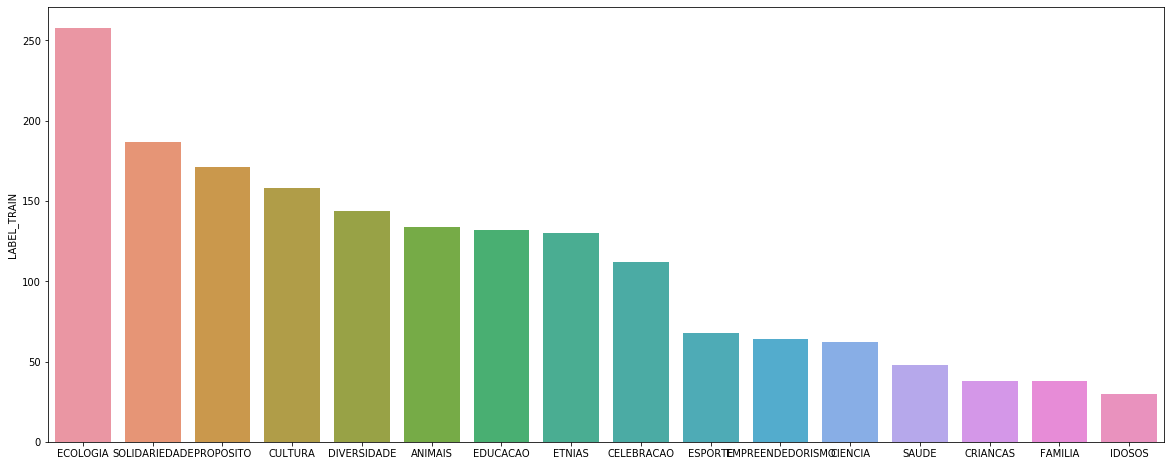

In [11]:
"""  Let"s see how the labels are distributed """
data_labels_count = df_preprocessed_data[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
average_samples_per_label = data_labels_count.mean()
standard_deviation_for_labels = data_labels_count.std()
print(
    "Mean number of samples for the target variable is: ",
    average_samples_per_label)
print(
    "Standard deviation number of samples for the target variable is: ",
    standard_deviation_for_labels)

''' Numerical analysis
    One way to analyse the frequency of certain labels is to notice with
    they're too afar from the other labels frequencies average. Let's use
    standard deviation to check it'''
def is_it_further_than_std_deviations( value ):
    is_too_much = value > average_samples_per_label + standard_deviation_for_labels
    is_too_little = value < average_samples_per_label - standard_deviation_for_labels
    if is_too_much or is_too_little:
        message = "Warning"
    else:
        message = "Okay"

    return message

for i in tqdm(range(0, len(data_labels), 2)):
    even_indexed_label = data_labels[i]
    odd_indexed_label = data_labels[i+1]

    print("{0:20}  {1:10} {2:15} {3:20} {4:10} {5:10}".format(
        even_indexed_label, data_labels_count[even_indexed_label], is_it_further_than_std_deviations(data_labels_count[even_indexed_label]),
        odd_indexed_label, data_labels_count[odd_indexed_label], is_it_further_than_std_deviations(data_labels_count[odd_indexed_label])))

''' Visual plotting'''
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()

### Results

Based on the previous step, we can see the categories **ECOLOGIA** and **SOLIDARIEDADE** have **more than the average added by the standard deviation** which can cause the model to overly recognise those labels patterns and make then too sensitive for those. 

On other hand we have the categories **FAMILIA**, **CRIANCAS** and **IDOSOS** with **less than the average subtracted by the standard deviation** which can make the model too specific for those and hardly classify as it.

Let's oversample the least common labels by grouping then. When our pipeline is finely tunned we can use the grouped labels as input for another pipeline trainned only to discern among those.
And also undersample the most common labels by ramdonly select less samples.


Let's check the labels found: 
Underpresented labels:  ['CRIANCAS', 'FAMILIA', 'IDOSOS']
Overrepresented labels:  ['ECOLOGIA', 'SOLIDARIEDADE']
Unchanged Labels:  ['CELEBRACAO', 'PROPOSITO', 'CULTURA', 'ANIMAIS', 'ESPORTE', 'ETNIAS', 'CIENCIA', 'SAUDE', 'EMPREENDEDORISMO', 'DIVERSIDADE', 'EDUCACAO']
ECOLOGIA            175
SOLIDARIEDADE       175
PROPOSITO           171
CULTURA             158
DIVERSIDADE         144
ANIMAIS             134
EDUCACAO            132
ETNIAS              130
CELEBRACAO          112
SCARCE_GROUP        106
ESPORTE              68
EMPREENDEDORISMO     64
CIENCIA              62
SAUDE                48
Name: LABEL_TRAIN, dtype: int64


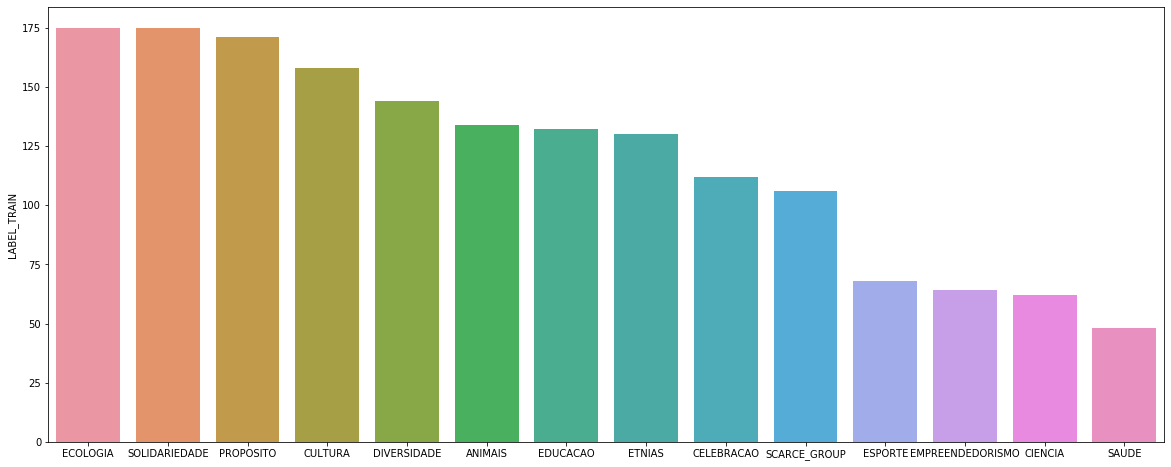

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1774 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 41.6+ KB
None


In [12]:
''' Let's create another dataframe and find which samples will be and how they'll be part of it'''
data_labels_count = df_preprocessed_data[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
under_represented_labels = []
over_represented_labels = []
max_number_of_samples = average_samples_per_label + standard_deviation_for_labels
min_number_of_samples = average_samples_per_label - standard_deviation_for_labels
for label in tqdm(data_labels):
    if data_labels_count[label] < min_number_of_samples:
        under_represented_labels.append(label)
    elif data_labels_count[label] > max_number_of_samples:
        over_represented_labels.append(label)

unchanged_labels = list(set(data_labels) - set(under_represented_labels) - set(over_represented_labels))

print("Let's check the labels found: ")
print("Underpresented labels: ", under_represented_labels)
print("Overrepresented labels: ", over_represented_labels)
print("Unchanged Labels: ", unchanged_labels)

df_preprocessed_grouped = pd.DataFrame(columns=df_preprocessed_data.columns)

for label in unchanged_labels:
    unchanged_rows = df_preprocessed_data[df_preprocessed_data[TARGET_VARIABLE] == label]
    df_preprocessed_grouped = df_preprocessed_grouped.append(unchanged_rows)

''' Now we have found which ones are under represented we'll add them to the new
    DataFrame and then change the under represented label to SCARCE_GROUP '''
for label in under_represented_labels:
    under_represented_rows = df_preprocessed_data[df_preprocessed_data[TARGET_VARIABLE] == label]
    df_preprocessed_grouped = df_preprocessed_grouped.append(under_represented_rows)

GROUP_TARGET_LABEL = 'SCARCE_GROUP'
df_preprocessed_grouped = df_preprocessed_grouped.replace(
    {TARGET_VARIABLE: under_represented_labels}, GROUP_TARGET_LABEL)

""" For the over represented, we'll select some of the samples."""
for label in over_represented_labels:
    over_represented_rows = df_preprocessed_data[
        df_preprocessed_data[TARGET_VARIABLE] == label].sample(int(max_number_of_samples))
    df_preprocessed_grouped = df_preprocessed_grouped.append(over_represented_rows)

print(df_preprocessed_grouped[TARGET_VARIABLE].value_counts())

"""  Let"s see how the labels are distributed """
data_labels_count = df_preprocessed_grouped[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()
print(df_preprocessed_data.info())

### Storing partial progress

In [13]:
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_treated_grouped.xlsx"

In [14]:
"""  Let"s store the  data """
df_preprocessed_grouped.to_excel(excel_filename)

## Data Partition
Now we have treated the data structure and sampling problems. Let's drop unwanted columns.

In [15]:
"""  We then load the data for stability """
df_data = pd.read_excel(excel_filename, index_col=0)
print(df_data.head())

   LABEL_TRAIN                                      TEXT_VARIABLE
53  CELEBRACAO  Brasileiros ganham a Olimpíada Internacional d...
66  CELEBRACAO  Aluno cria máquina para pessoas em coma “falar...
75  CELEBRACAO  Conheça o brasileiro indicado ao Prêmio Nobel ...
85  CELEBRACAO  Brasileiros podem entrar em mais de 100 países...
87  CELEBRACAO  Ex-dependente, morador de albergue, passa em 3...


## Text Filter(Preprocessing)

Before we train the model, it's necessary to tokenize words, find their lemmas and discard some words that could mislead the model.

Let's take a first look at the text variable.

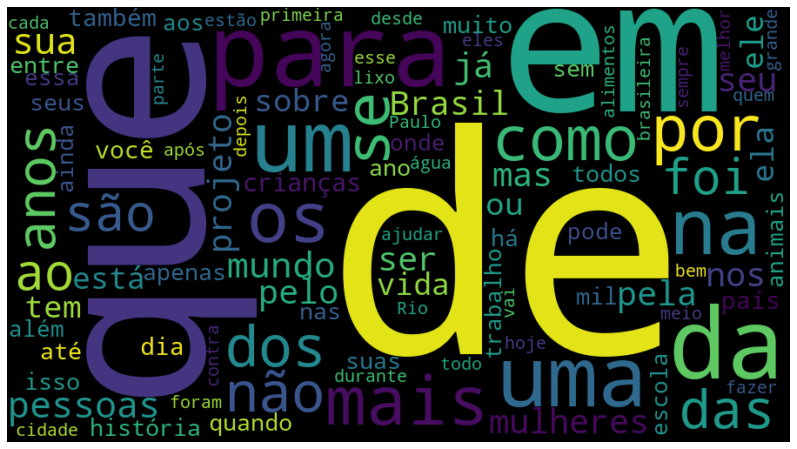

,       5033
de      4437
.       3031
a       2477
e       2442
que     1878
o       1876
do      1356
em      1315
para    1266
da      1246
um       879
com      847
uma      846
no       762
é        754
na       688
mais     543
os       514
por      447
A        434
as       428
se       425
-        417
como     409
dtype: int64


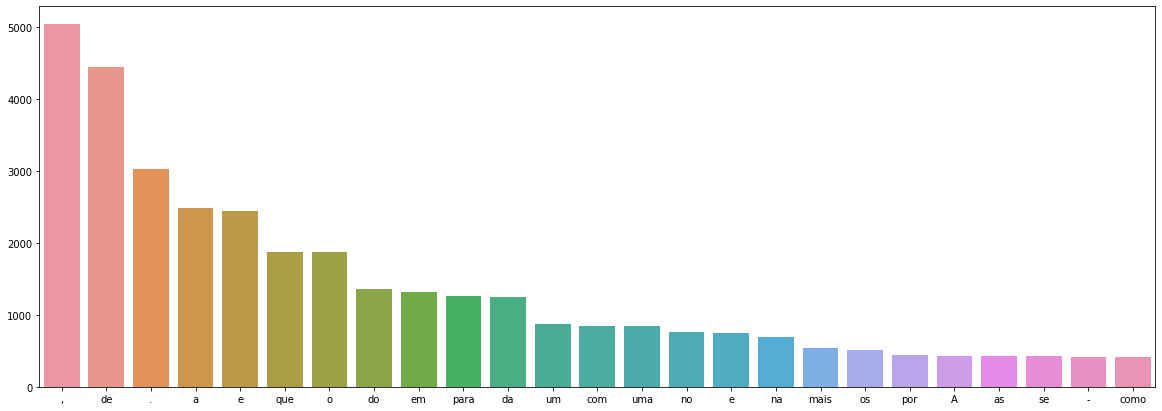

In [16]:
text_variable = 'TEXT_VARIABLE'
raw_text_column = df_data[text_variable]
generate_wordcloud(raw_text_column)
print(generate_freq_dist_plot(raw_text_column))

### Symbols and stopwords

As we can see, we have a lot of tokens from text variable being symbols or words that don't have by themselves much meaning. Let's fix that.
We can also strip trailing spaces and remove multiple spaces.

In [17]:
stopwords_set = set(STOP_WORDS).union(set(stopwords.words('portuguese'))).union(set(['anos', 'ano', 'dia', 'dias']))
stopword_pattern = r'\b(?:{})\b'.format(r'|'.join(stopwords_set))
symbols_pattern = r'(?:[{}]|[^\w\s])'.format(punctuation)
space_pattern = r'\s\s+'
number_pattern = r'\d'
print("This is the stopword list: ", sorted(list(stopwords_set)))
print("This is the number pattern:", number_pattern)
print("This is the symbols pattern: ", symbols_pattern)
print("This is the space pattern:", space_pattern)

This is the stopword list:  ['a', 'acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'ano', 'anos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'as', 'assim', 'através', 'atrás', 'até', 'aí', 'baixo', 'bastante', 'bem', 'boa', 'bom', 'breve', 'cada', 'caminho', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'com', 'como', 'comprida', 'comprido', 'conhecida', 'conhecido', 'conselho', 'contra', 'contudo', 'corrente', 'cuja', 'cujo', 'custa', 'cá', 'da', 'daquela', 'daquele', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'des', 'desde', 'dessa', 'desse', 'desta', 'deste', 'deve', 'devem', 'deverá', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'dias', 'direita', 'disso', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dá', 'dã

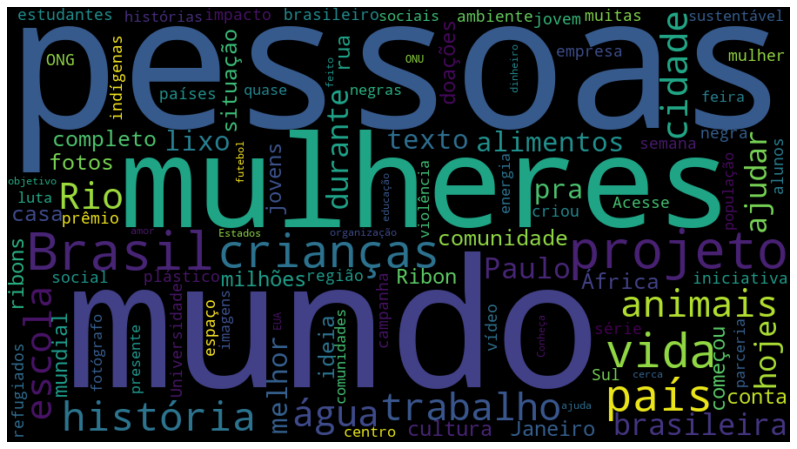

pessoas      237
mundo        206
Brasil       180
mulheres     169
projeto      145
vida         140
crianças     133
país         125
história      99
animais       89
trabalho      87
cidade        84
água          84
ajudar        81
Rio           80
Paulo         76
escola        70
texto         68
ideia         65
lixo          65
África        64
completo      64
melhor        63
alimentos     63
pra           62
dtype: int64


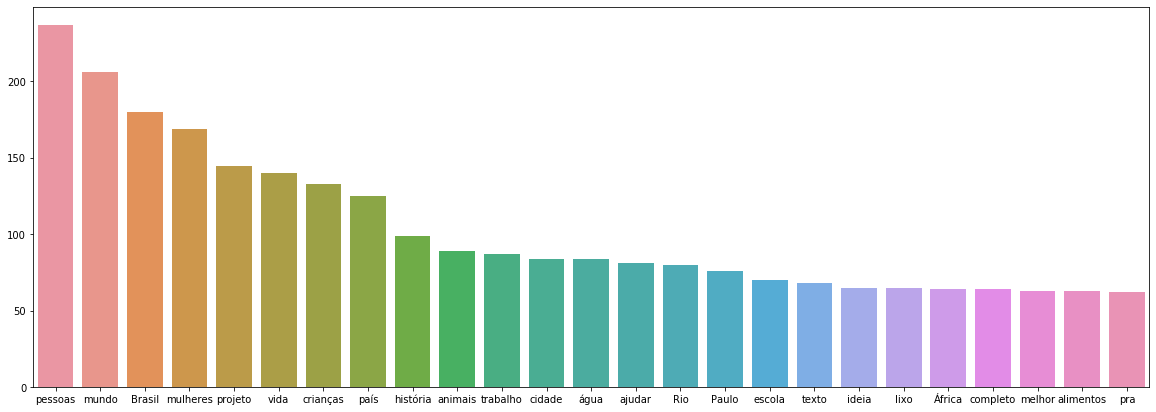

In [19]:
''' Processing text on caracteres level'''
df_data['PREPROCESSED_TEXT'] = df_data[text_variable]
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    number_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    stopword_pattern, " ", case=False)
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    symbols_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    space_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.strip()
generate_wordcloud(df_data['PREPROCESSED_TEXT'])
print(generate_freq_dist_plot(df_data['PREPROCESSED_TEXT']))

### Results
Now the most common words are way more expressive.

### Lemmatizing and stemming


['tagger', 'sentencizer', 'parser', 'ner']



Documents without lemmatization
pessoas      237
mundo        206
Brasil       180
mulheres     169
projeto      145
vida         140
crianças     133
país         125
história      99
animais       89
trabalho      87
água          84
cidade        84
ajudar        81
Rio           80
Paulo         76
escola        70
texto         68
ideia         65
lixo          65
África        64
completo      64
melhor        63
alimentos     63
hoje          62
dtype: int64


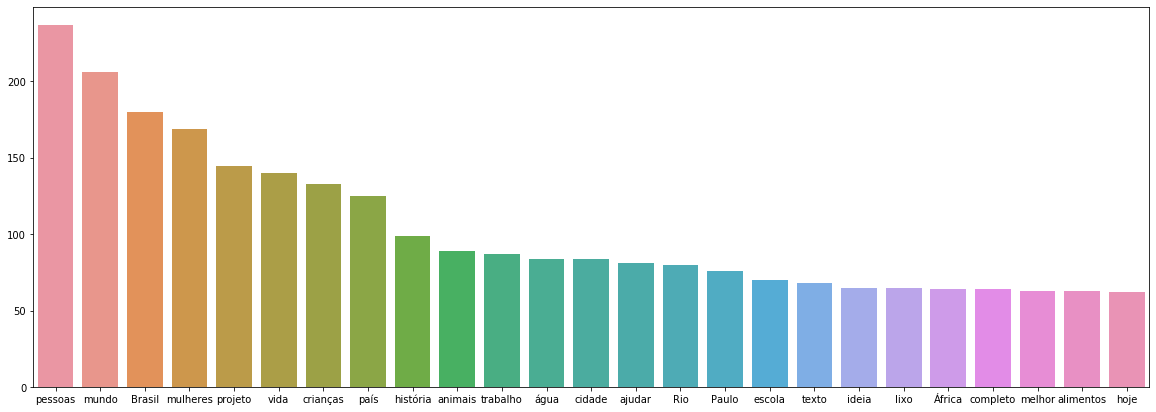

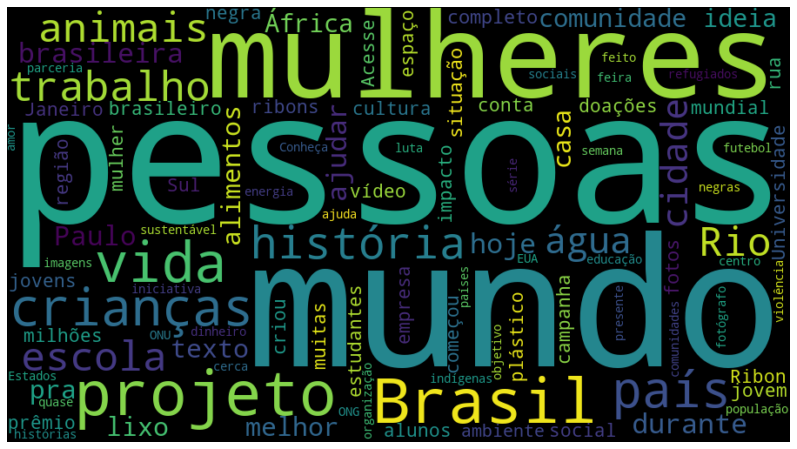

Documents with minor lemmatization
pessoas       242
mundo         222
mulheres      199
projeto       181
brasil        180
vida          144
crianças      138
país          129
história      104
trabalho       93
escola         90
animais        90
rio            86
água           86
cidade         86
brasileira     81
ajudar         81
hoje           80
durante        80
paulo          76
alimentos      69
lixo           69
melhor         68
texto          68
pra            67
dtype: int64


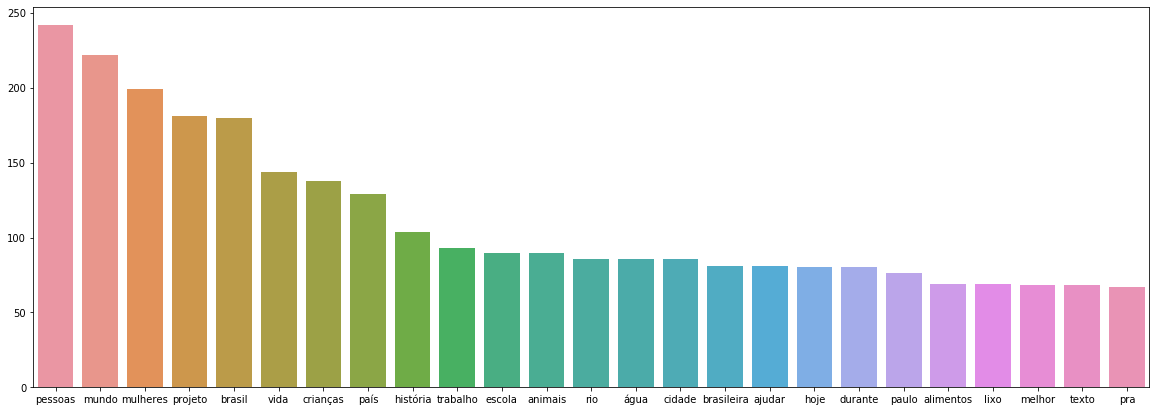

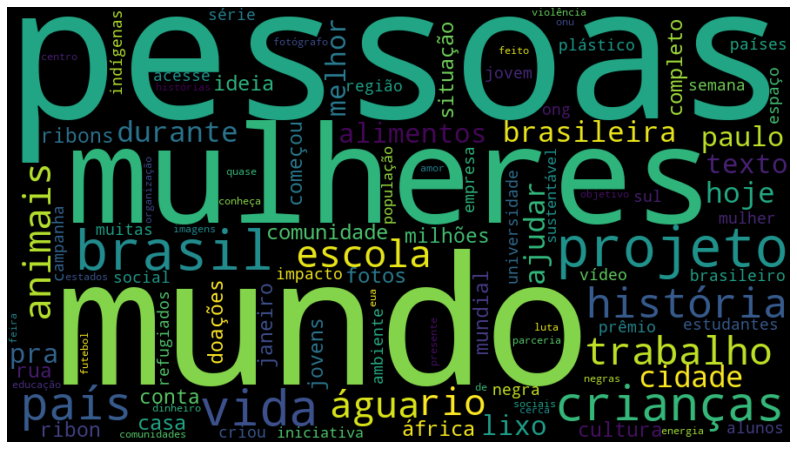

Documents with full lemmatization
pessoa        255
mulher        206
mundo         206
criar         188
Brasil        180
ajudar        173
vidar         164
país          164
trabalhar     152
passar        152
criança       149
brasileiro    146
projeto       145
história      136
casar         115
negro         111
cidade        107
contar        104
fazer         103
comunidade     99
escola         96
animar         93
viver          91
jovem          90
água           90
dtype: int64


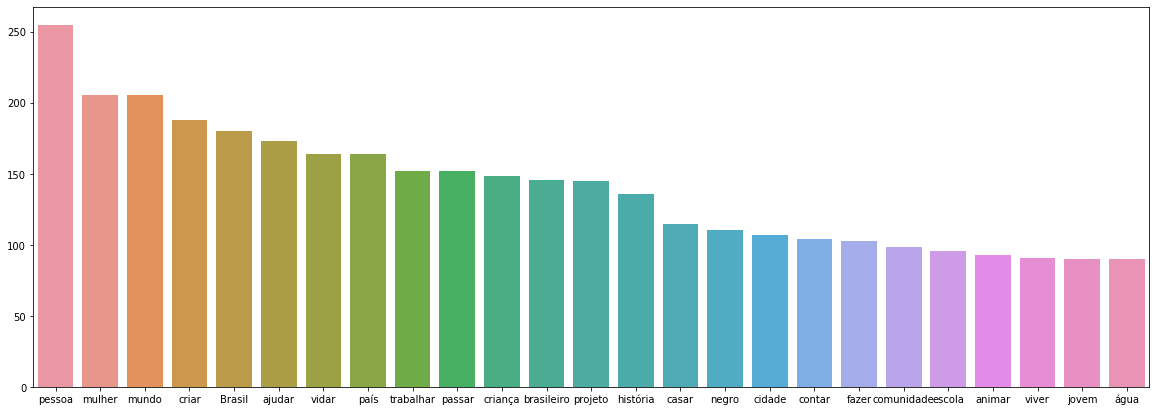

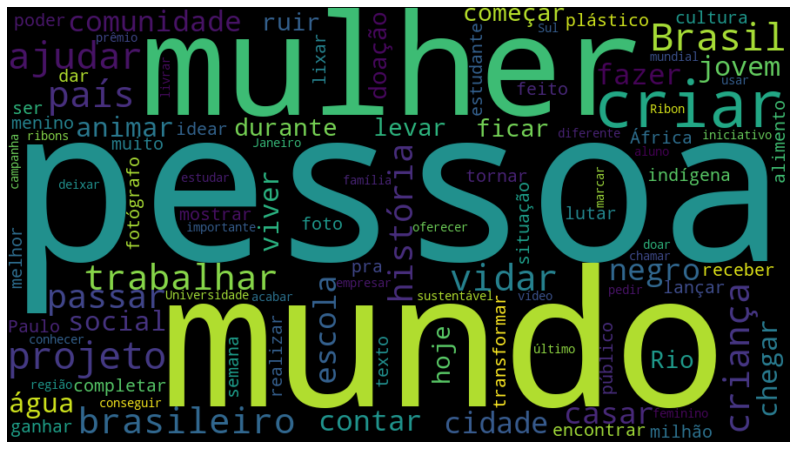

In [20]:
preprocessed_text_data = df_data['PREPROCESSED_TEXT'].to_list()
''' Not all variables are being undestood as strings so we have to force it'''

sentencizer = NLP_SPACY.create_pipe('sentencizer')
''' Create the pipeline 'sentencizer' component '''

try:
    ''' We then add the component to the pipeline if we hadn't done before '''
    NLP_SPACY.add_pipe(sentencizer, before='parser')
except ValueError:
    print("Pipe already present.")

print(NLP_SPACY.pipe_names)

tokenized_data = []
semantics_data = []
lemmatized_doc = []
normalized_doc = []
raw_doc = []
for row in tqdm(preprocessed_text_data):
    doc = NLP_SPACY(row)
    tokenized_data.append(doc)
    raw_doc.append(
        " ".join(
            [word.text for word in doc]))
    lemmatized_doc.append(
        " ".join(
            [word.lemma_ for word in doc]))
    normalized_doc.append(
        " ".join(
            [word.norm_ for word in doc]))
    
df_data['RAW_DOC'] = raw_doc
df_data['NORMALIZED_DOC'] = normalized_doc
df_data['LEMMATIZED_DOC'] = lemmatized_doc

print("Documents without lemmatization")
print(generate_freq_dist_plot(df_data['RAW_DOC']))
generate_wordcloud(df_data['RAW_DOC'])
print("Documents with minor lemmatization")
print(generate_freq_dist_plot(df_data['NORMALIZED_DOC']))
generate_wordcloud(df_data['NORMALIZED_DOC'])
print("Documents with full lemmatization")
print(generate_freq_dist_plot(df_data['LEMMATIZED_DOC']))
generate_wordcloud(df_data['LEMMATIZED_DOC'])



### Entity Recognition
Some parts of speech may mislead the model associating classes to certain entities that are not really related to the categories.
The NER model(spacy portuguese) we are using uses the following labels:

| TYPE | DESCRIPTION |
|------|-------------------------------------------------------------------------------------------------------------------------------------------|
| PER | Named person or family. |
| LOC | Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains). |
| ORG | Named corporate, governmental, or other organizational entity. |
| MISC | Miscellaneous entities, e.g. events, nationalities, products or works of art. |

Let's take a look at the named persons or families

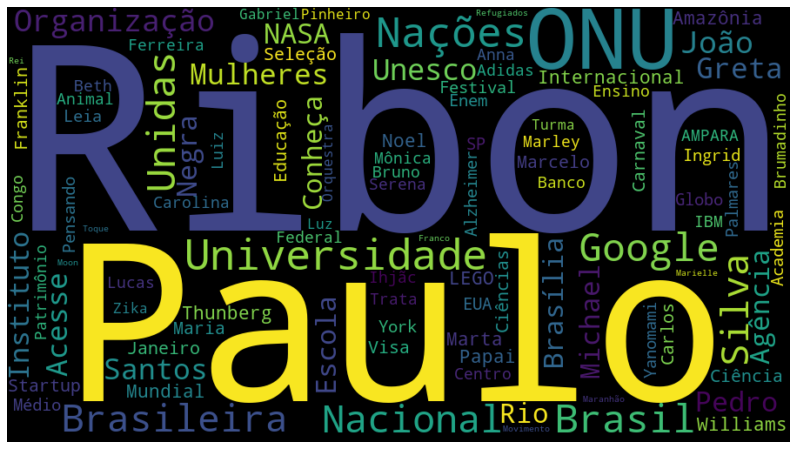

Ribon           47
Paulo           45
ONU             30
Universidade    19
Nações          18
Brasil          16
Unidas          16
Google          16
Nacional        15
João            14
Silva           14
Greta           12
Santos          12
Acesse          12
Pedro           11
Brasileira      11
Instituto       11
Mulheres        11
Organização     11
Rio             10
Michael         10
Escola          10
Brasília        10
Conheça         10
Negra           10
dtype: int64


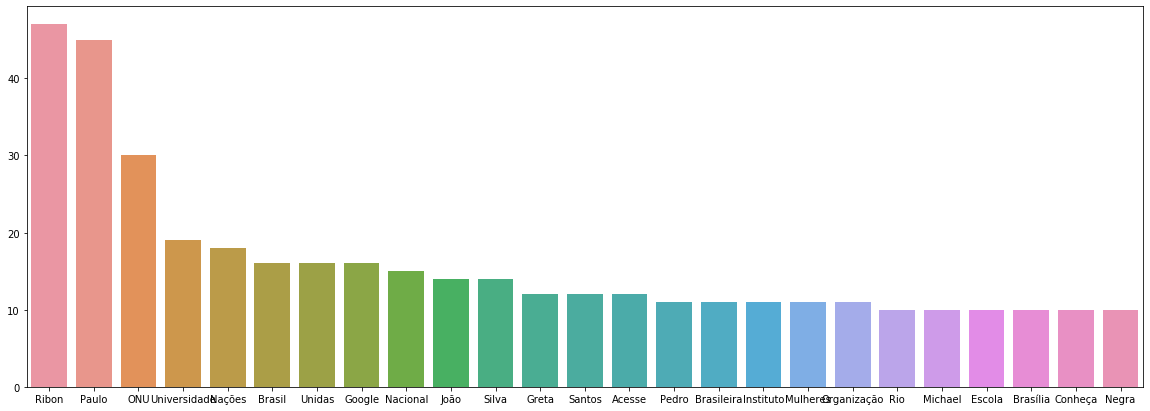

In [21]:
''' First we take a look at the found entities'''
entities_lists = []
entity_unwanted_types = set(['PER', 'ORG'])

for docs in tokenized_data:
    entities_text = ""
    for entity in docs.ents:
        if entity.label_ in entity_unwanted_types:
            entities_text += " " + entity.text
    entities_text = entities_text.strip()
    entities_lists.append(entities_text)
            
df_data['ENTITIES'] = entities_lists
generate_wordcloud(df_data['ENTITIES'])
print(generate_freq_dist_plot(df_data['ENTITIES']))

### Removing Entities

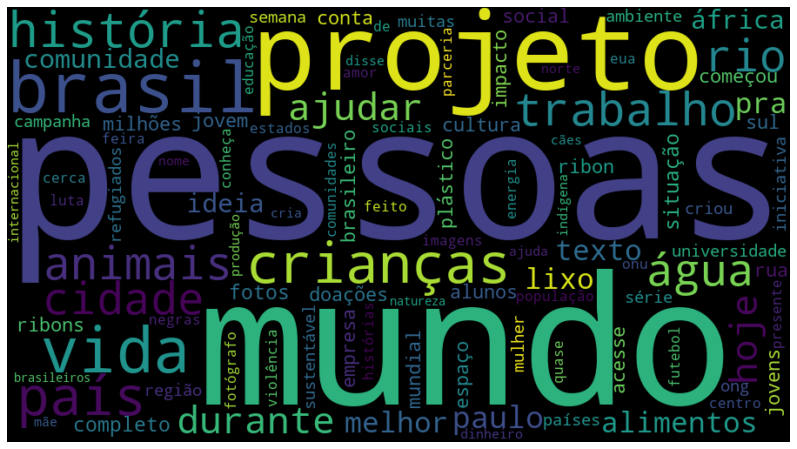

pessoas       242
mundo         222
projeto       181
brasil        180
vida          144
crianças      138
país          129
história      104
trabalho       93
animais        90
cidade         86
água           86
rio            86
ajudar         81
durante        80
hoje           80
paulo          76
lixo           69
alimentos      69
texto          68
melhor         68
pra            67
ideia          65
comunidade     65
áfrica         64
dtype: int64


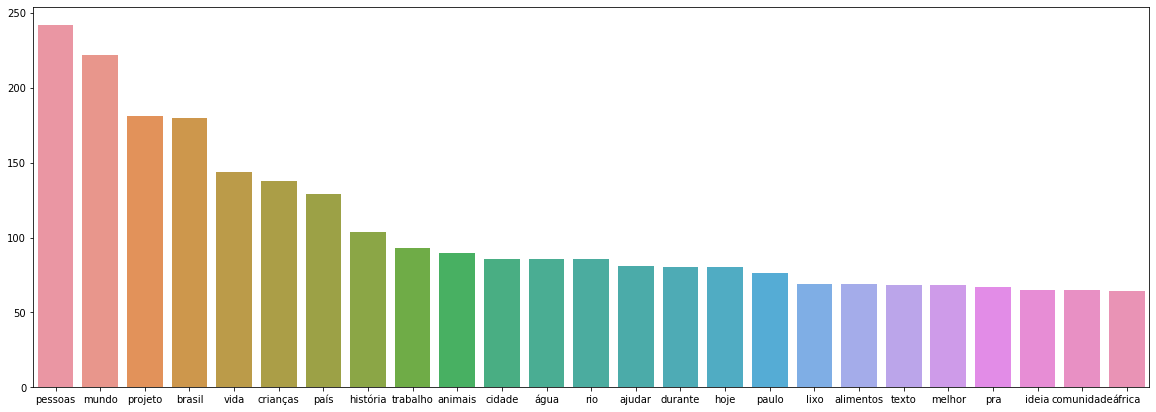

In [22]:
entities_set = set()
entities_set = set([ word for word_list in list(map(list, df_data['ENTITIES'].str.split(" ")))
                            for word in word_list ])
entities_set.remove("")
entities_pattern = r'\b(?:{})\b'.format('|'.join(entities_set)) 

''' Processing text on entity level'''
df_data['PROCESSED_DOC'] = df_data['NORMALIZED_DOC'].str.replace(entities_pattern, " ")
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

### POS Analysis
Let's take a look in the parts of speech presents in the dataset

PROPN    13602
NOUN     10432
VERB      9550
ADJ       6756
ADV        885
DET        512
ADP        313
AUX        307
PRON        81
SYM         74
X           47
NUM         34
CCONJ       19
SCONJ       13
PUNCT        9
SPACE        9
PART         2
dtype: int64


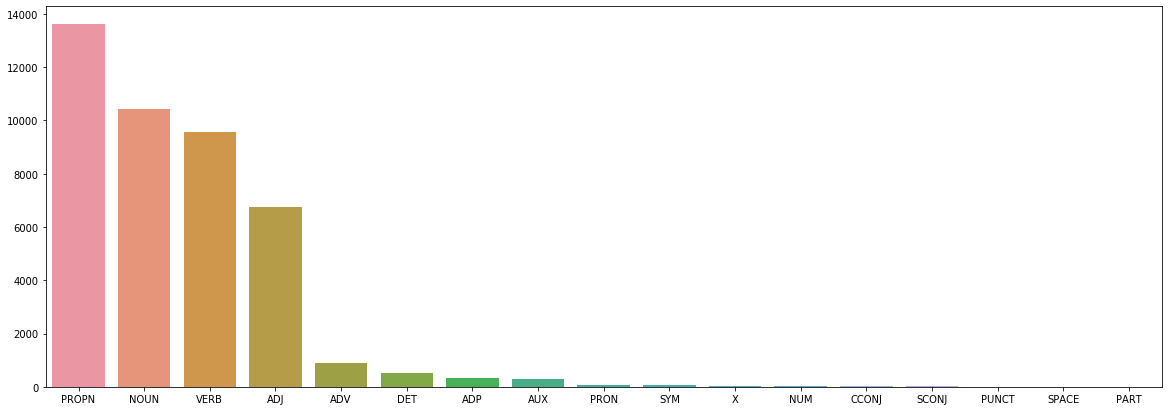

In [23]:
semantics_data = []
for doc in tokenized_data:
    semantics_data.append(" ".join([word.pos_ for word in doc]))

df_data['SEMANTICS'] = semantics_data
print(generate_freq_dist_plot(df_data['SEMANTICS']))

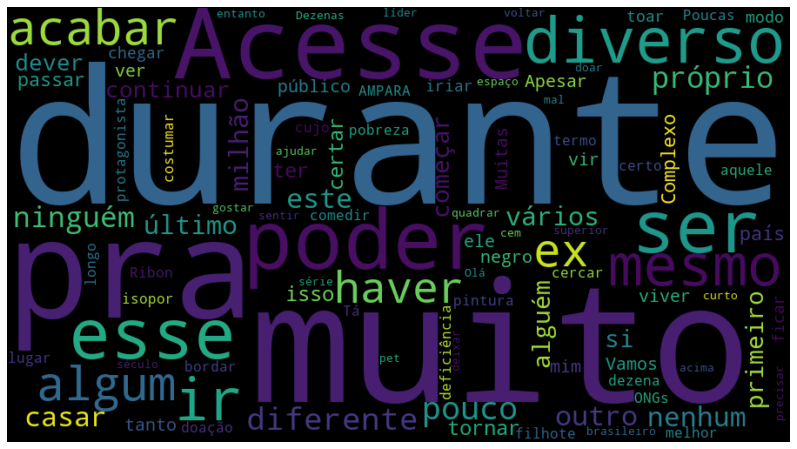

muito        64
pra          62
durante      59
d            43
poder        42
Acesse       41
ser          32
esse         29
o            27
diverso      27
ir           23
mesmo        23
n            22
acabar       21
Durante      21
algum        20
haver        17
pouco        17
º            16
diferente    16
D            15
próprio      14
ex           13
outro        12
este         12
dtype: int64


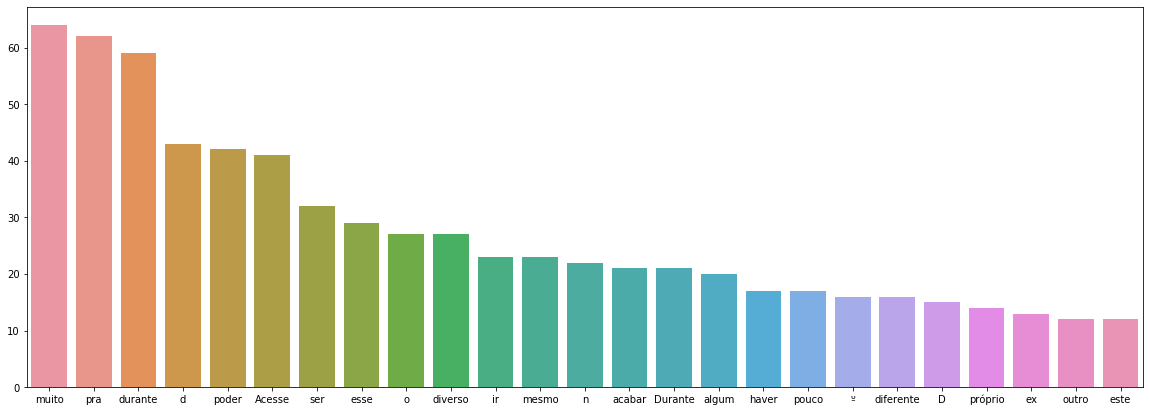

In [24]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

unwanted_pos_text = []
for doc in tokenized_data:
    unwanted_pos_text.append(
        " ".join(
            [word.lemma_ if not str(word.pos_) in ALLOWED_POS else "" for word in doc]))
    
df_data['UNWANTED_POS'] = unwanted_pos_text
generate_wordcloud(df_data['UNWANTED_POS'])
print(generate_freq_dist_plot(df_data['UNWANTED_POS']))

### Removing POS

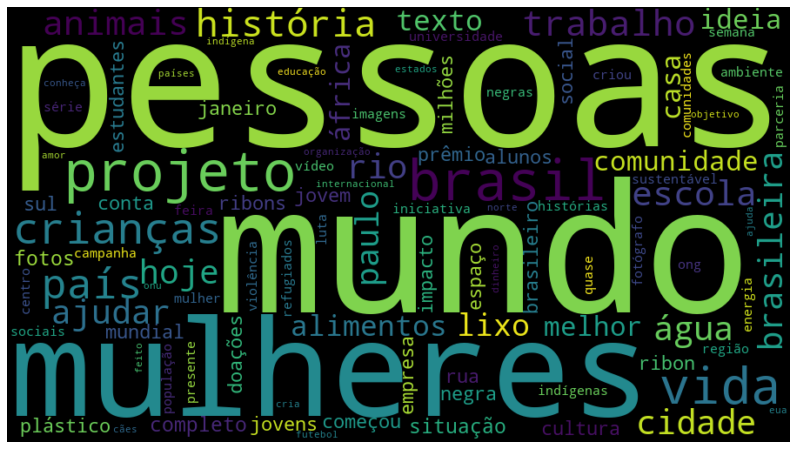

pessoas       242
mundo         222
mulheres      199
projeto       181
brasil        180
vida          144
crianças      138
país          129
história      104
trabalho       93
escola         90
animais        89
cidade         86
água           86
rio            85
brasileira     81
hoje           80
ajudar         80
paulo          76
lixo           69
alimentos      68
texto          68
ideia          65
melhor         65
casa           65
dtype: int64


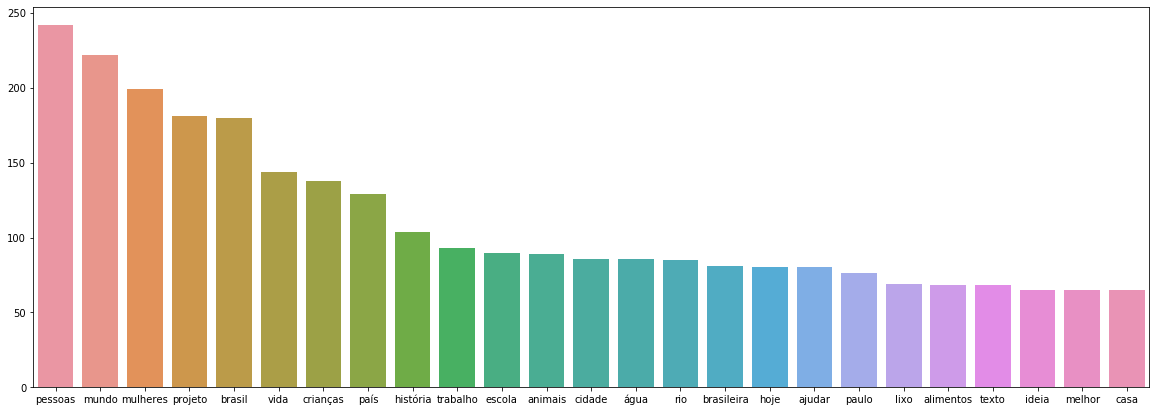

In [89]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

processed_doc = []
processed_doc_tokens = []
for doc in tokenized_data:
    doc_tokens = [word.norm_ if str(word.pos_) in ALLOWED_POS and word not in entities_set else "" for word in doc]
    processed_doc_tokens.append(doc_tokens)
    processed_doc.append(
        " ".join(doc_tokens))

df_data['PROCESSED_DOC'] = processed_doc
df_data['PROCESSED_DOC_TOKENS'] = processed_doc_tokens
''' Processing text on entity level again '''
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

In [90]:
""" Removing extra spaces originated from processing """
df_data['PROCESSED_DOC'] = df_data['PROCESSED_DOC'].str.replace(space_pattern, " ").str.strip()
df_data['UNWANTED_POS'] = df_data['UNWANTED_POS'].str.replace(space_pattern, " ").str.strip()

### Viewing the most common words for each label

Label:  CELEBRACAO
prêmio           26
mulheres         23
brasileira       20
mundo            16
trabalho         15
brasil           15
ciência          13
jovens           13
nobel            12
país             11
internacional    11
pessoas          10
vida             10
greta            10
bióloga          10
projeto          10
negra             9
onu               9
paz               8
sul               8
estudantes        8
universidade      7
música            7
história          7
jovem             7
dtype: int64


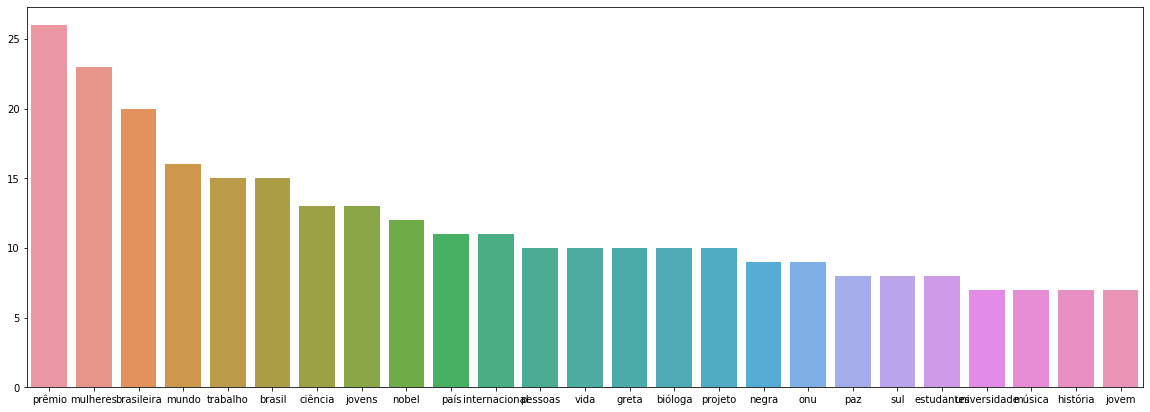

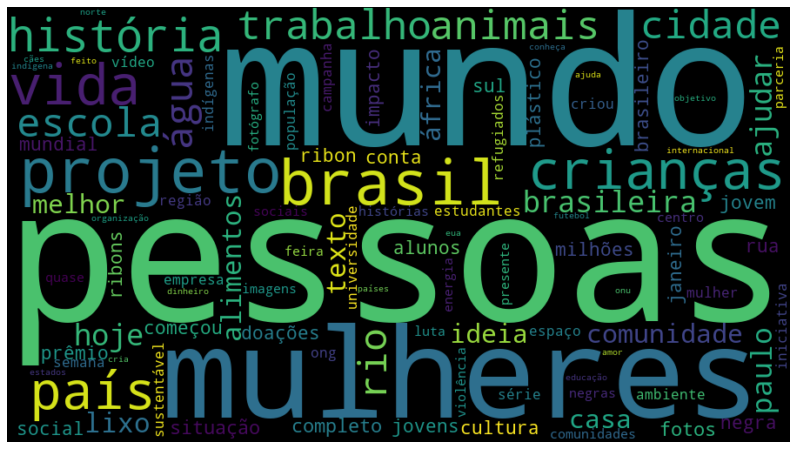

Label:  PROPOSITO
ribons        46
ribon         43
doações       35
pessoas       25
mundo         23
impacto       20
presente      19
visa          16
completo      16
comunidade    16
ajudar        16
doados        15
texto         15
app           15
boas          14
doar          14
projeto       13
doadores      12
hoje          11
milhões       11
doação        11
crianças      11
causas        10
trabalho      10
usuários      10
dtype: int64


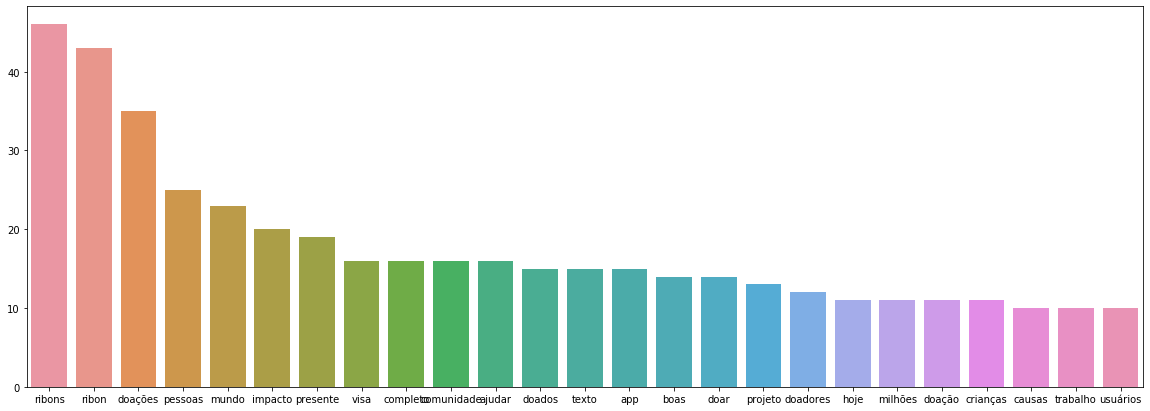

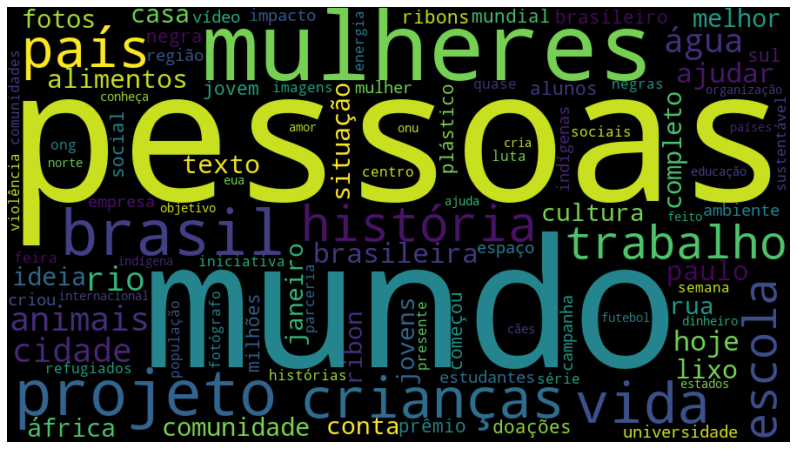

Label:  CULTURA
brasil         42
mulheres       28
rio            25
mundo          24
história       23
cultura        21
cultural       18
brasileira     18
janeiro        18
pessoas        17
vida           15
texto          15
fotos          15
carnaval       14
escola         14
completo       14
fotógrafo      13
patrimônio     13
resistência    12
paulo          12
negros         12
hoje           11
povos          10
terra          10
indígenas      10
dtype: int64


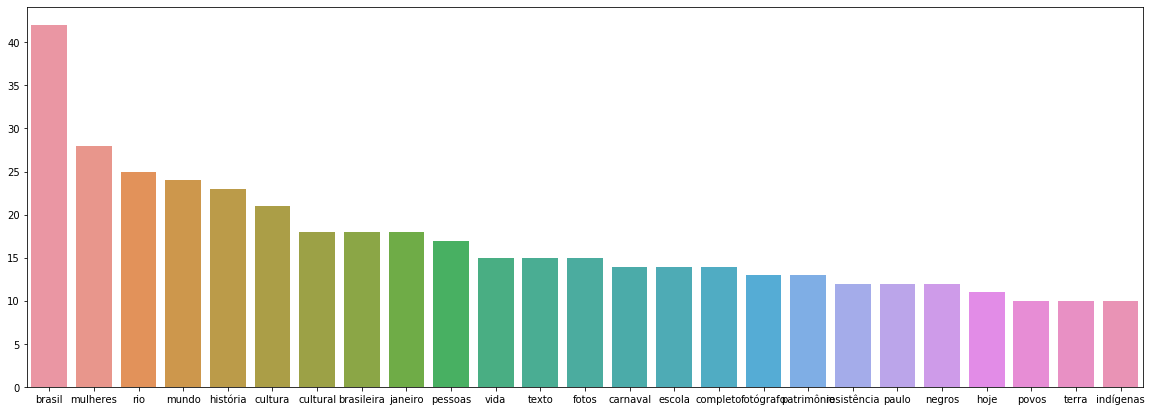

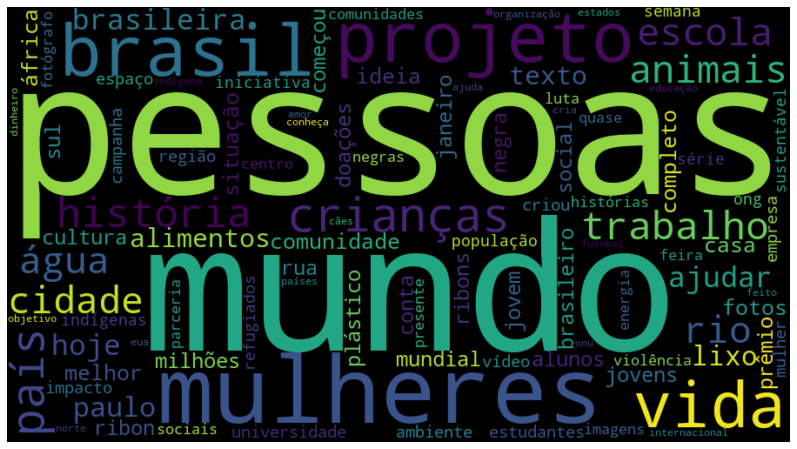

Label:  ANIMAIS
animais        69
cães           36
vida           22
animal         21
elefantes      18
cachorros      14
extinção       13
pessoas        13
rua            12
gatos          12
ong            11
espécie        10
abandonados    10
amor           10
espécies       10
mundo          10
cão             9
vídeo           9
país            9
situação        9
texto           8
tartarugas      8
ideia           8
vira            8
cidade          8
dtype: int64


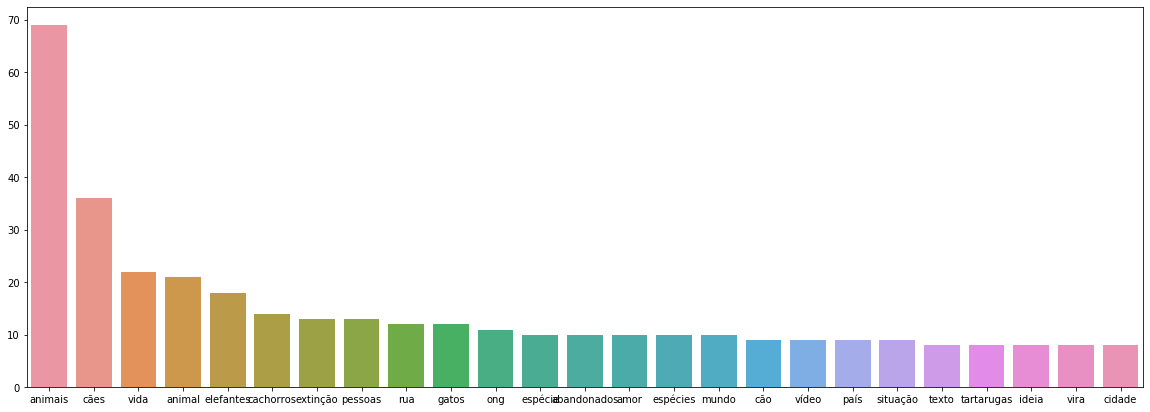

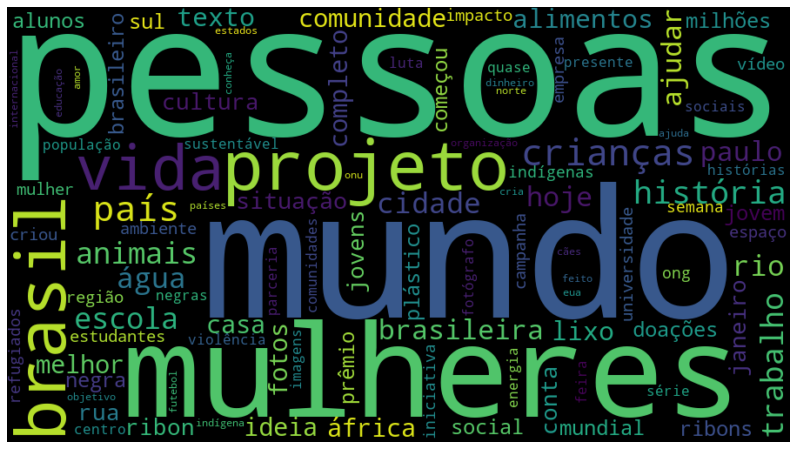

Label:  ESPORTE
futebol       27
seleção       20
mundo         19
copa          18
mundial       14
brasil        13
história      12
brasileira    11
feminina      10
jogos         10
histórias     10
projeto       10
feminino      10
atletas        9
mulheres       9
país           8
pessoas        8
esporte        8
gols           7
campeonato     7
atleta         7
conta          6
camisa         6
jitsu          6
marta          6
dtype: int64


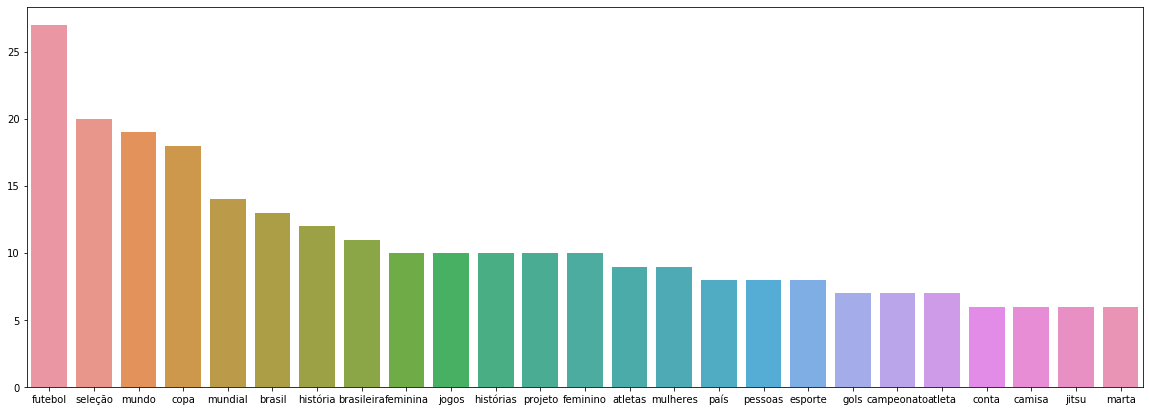

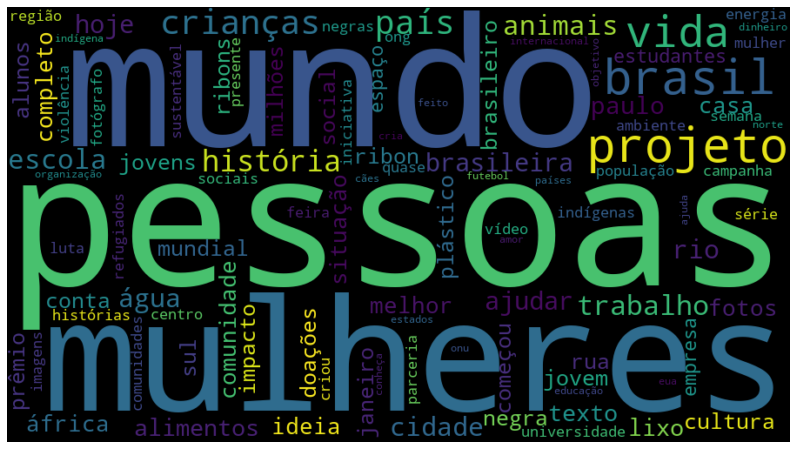

Label:  ETNIAS
mulheres      33
país          29
indígenas     29
áfrica        23
fotos         22
mundo         22
brasil        20
cultura       17
indígena      16
história      16
pessoas       15
fotógrafo     15
série         15
povos         14
vida          14
continente    14
hoje          14
imagens       13
texto         12
completo      11
região        11
guerra        10
congo         10
floresta       9
projeto        9
dtype: int64


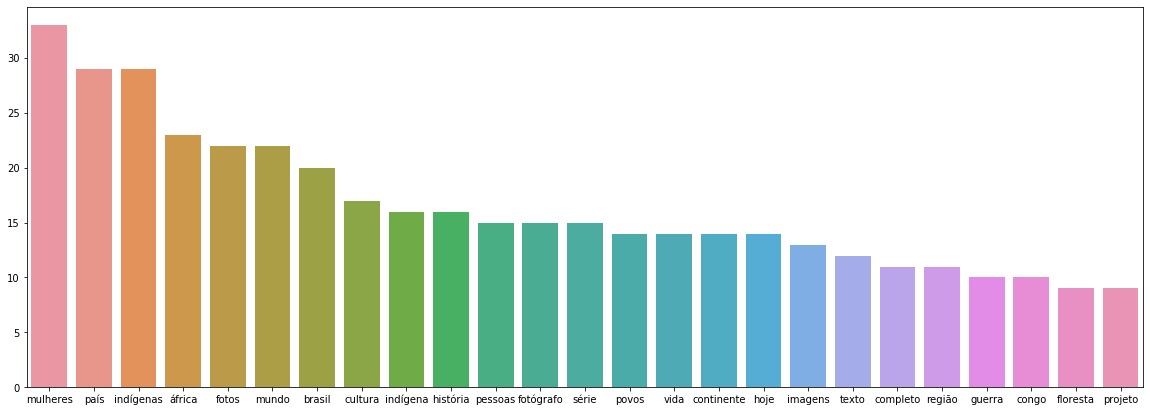

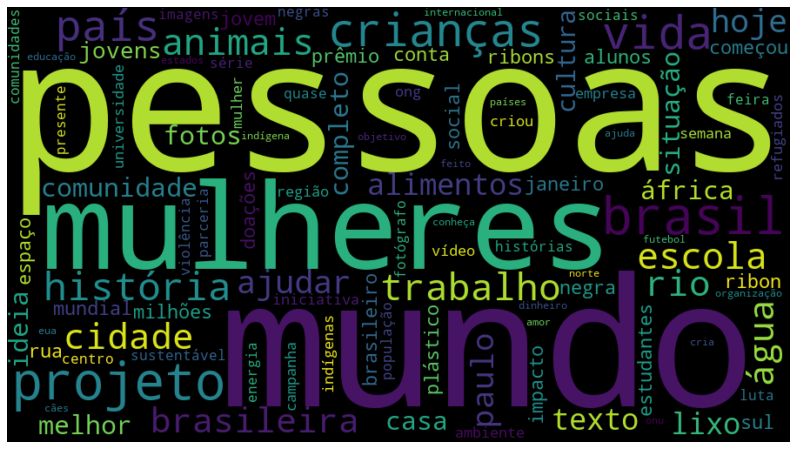

Label:  CIENCIA
água           16
nasa           14
mulheres       11
espaço         11
espacial       10
jovem          10
tecnologia      9
brasileira      9
prêmio          9
criou           9
sinais          8
cientistas      7
pessoas         7
ciência         7
garrafa         6
lixo            6
ideia           6
brasileiro      6
unidos          6
estados         6
plástico        5
lua             5
missão          5
astronautas     5
christina       5
dtype: int64


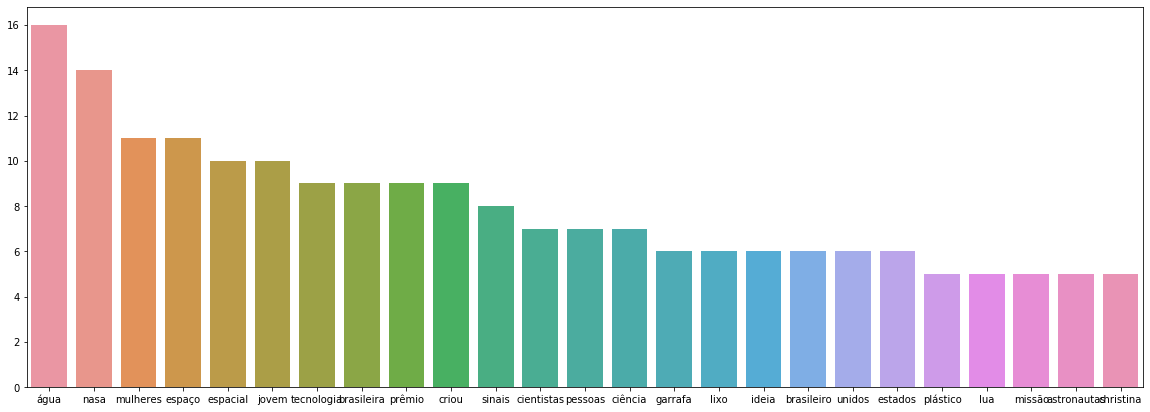

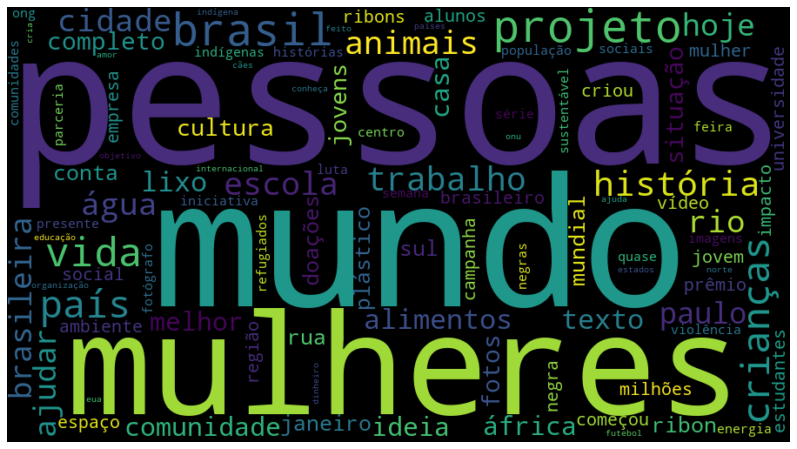

Label:  SAUDE
pessoas        15
morte           8
saúde           8
vida            7
doença          7
médico          6
mundo           6
pacientes       6
natureza        6
escrever        5
organização     5
brasil          5
crianças        5
libras          5
projeto         5
ajudar          5
diversão        4
pesquisa        4
melhor          4
corpo           4
cirurgia        4
ajuda           4
doenças         4
acesso          4
pesquisas       4
dtype: int64


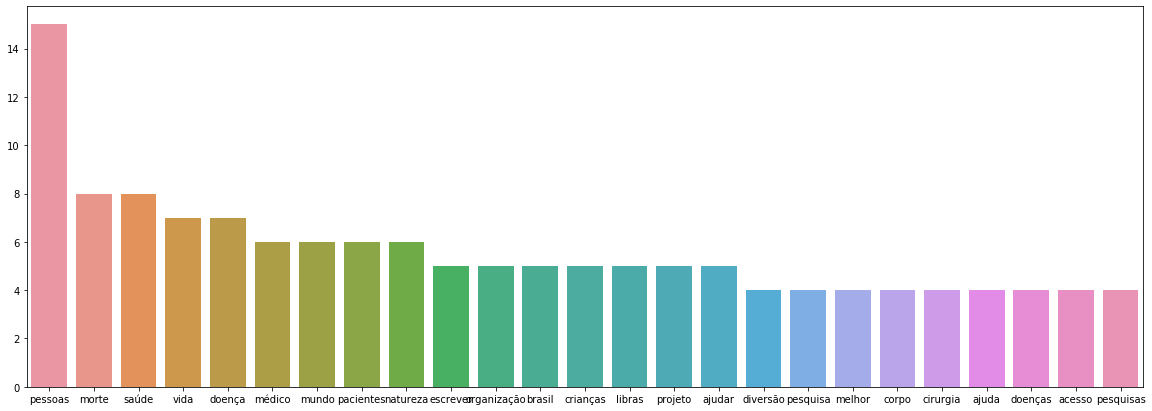

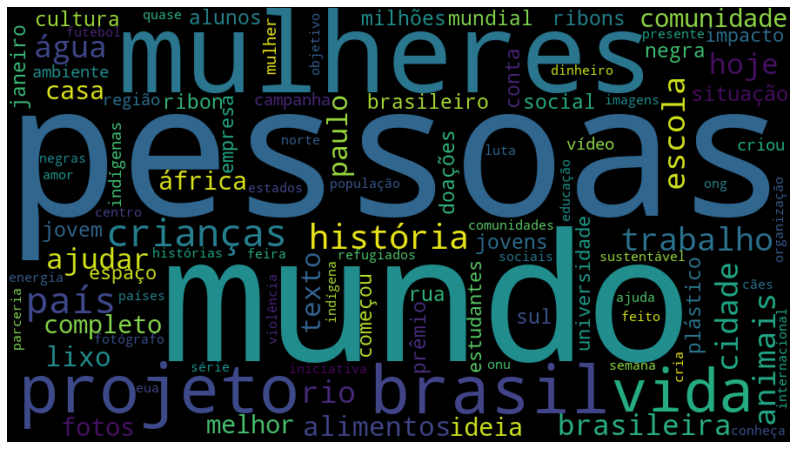

Label:  EMPREENDEDORISMO
mulheres       29
projeto        26
pessoas        18
alimentos      15
mundo          15
violência      13
brasil         12
trabalho       10
situação        9
algodão         9
comunidades     9
projetos        8
iniciativa      8
produção        8
desperdício     8
vida            8
social          7
país            7
sp              7
comunidade      7
paulo           7
onu             7
negras          7
máquina         6
dinheiro        6
dtype: int64


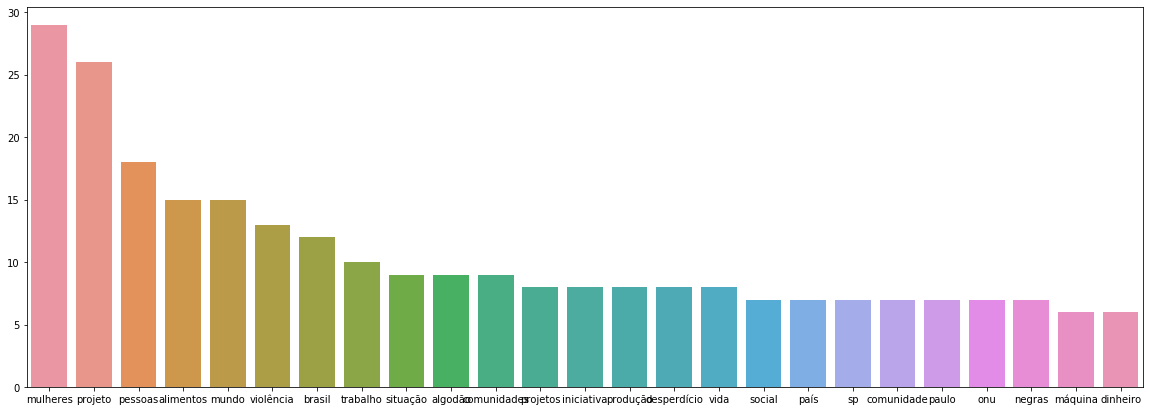

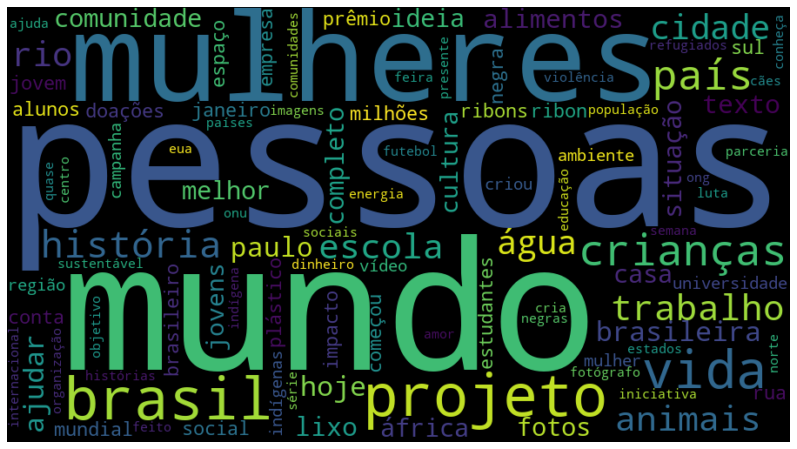

Label:  DIVERSIDADE
mulheres           33
pessoas            27
braille            17
crianças           17
brasil             15
mundo              15
deficiência        13
projeto            13
luta               12
diversidade        10
lei                10
nome               10
negra              10
lego                9
hoje                9
igualdade           9
visuais             9
social              9
pele                9
inclusão            9
empresa             8
desenvolvimento     8
estudantes          8
direitos            8
gênero              8
dtype: int64


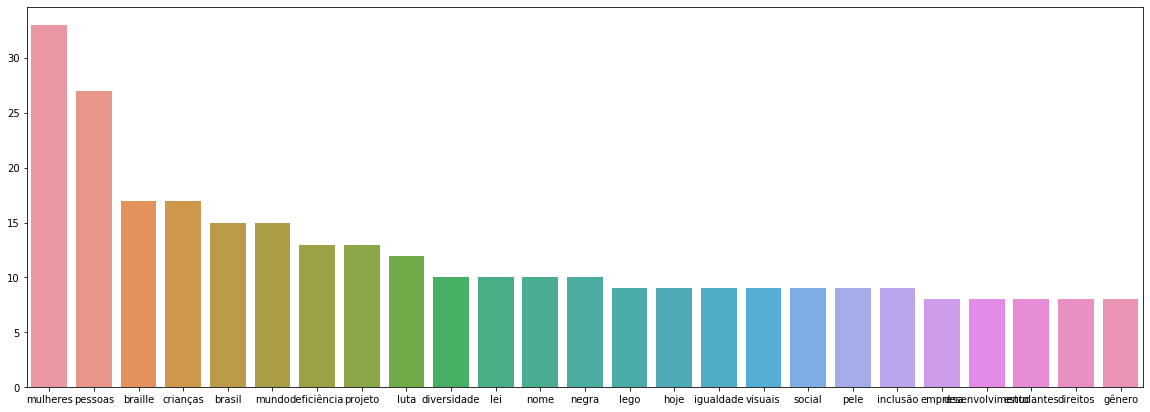

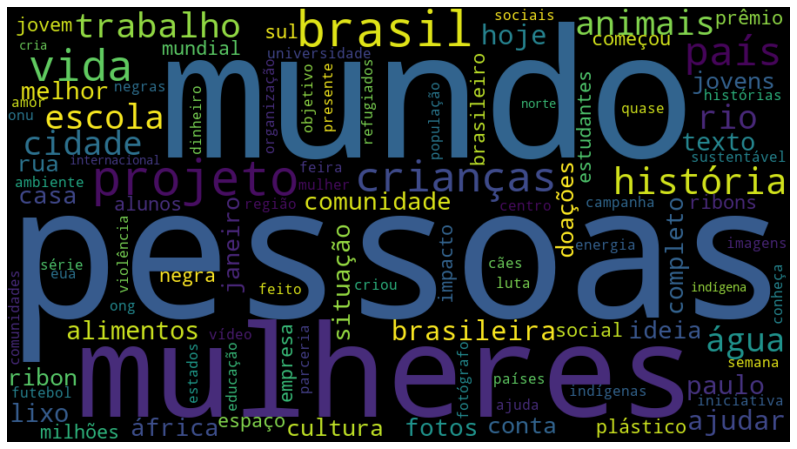

Label:  EDUCACAO
escola          38
crianças        35
projeto         28
alunos          27
estudantes      21
educação        20
escolas         17
brasil          17
mundo           16
rio             14
ensino          12
trabalho        12
pessoas         12
enem            12
melhor          12
cidade          11
casa            11
livros          11
universidade    11
música          11
país            11
professor       10
janeiro         10
aulas           10
pública          9
dtype: int64


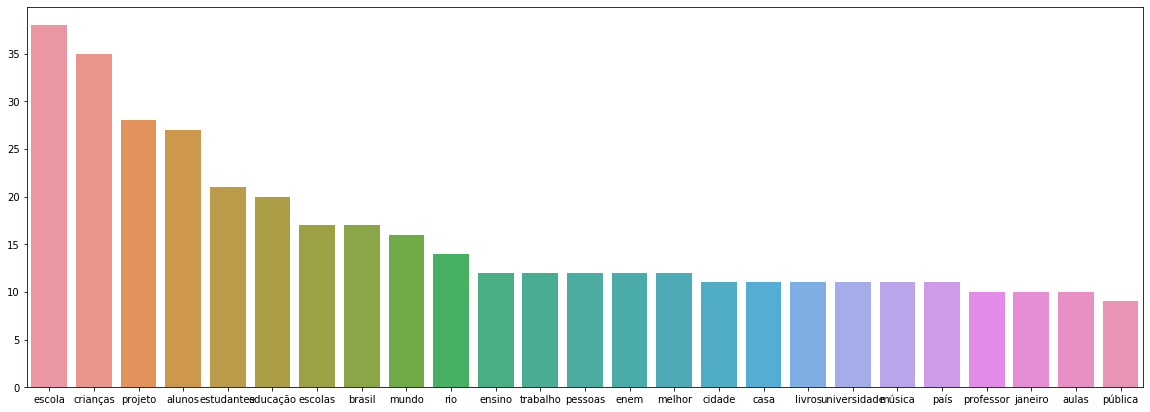

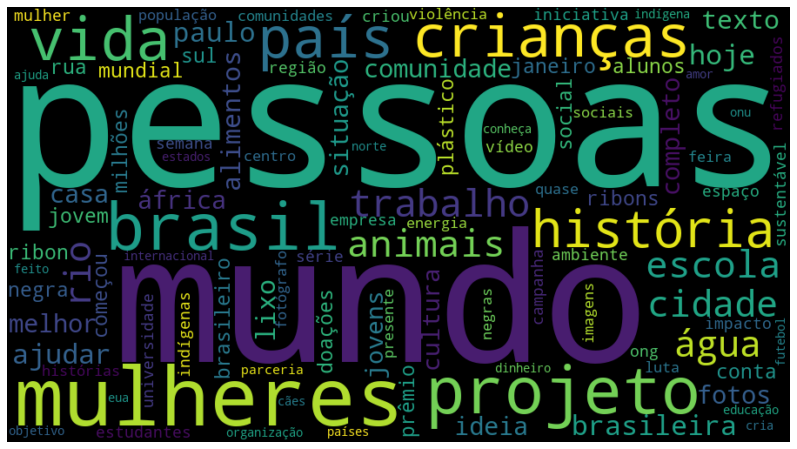

Label:  SCARCE_GROUP
crianças    22
mãe         18
vida        13
amor        12
história    11
mundo       11
filha       10
pessoas     10
cidade       9
pai          9
filhos       8
mães         8
idosos       8
filho        8
natal        8
começou      7
casa         7
escola       6
criança      6
paulo        6
fotos        6
câncer       6
hoje         6
hospital     5
conta        5
dtype: int64


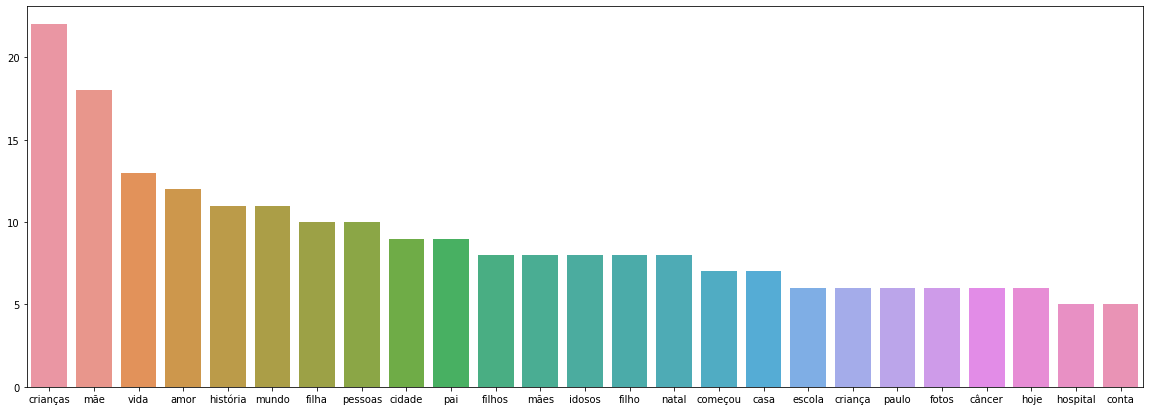

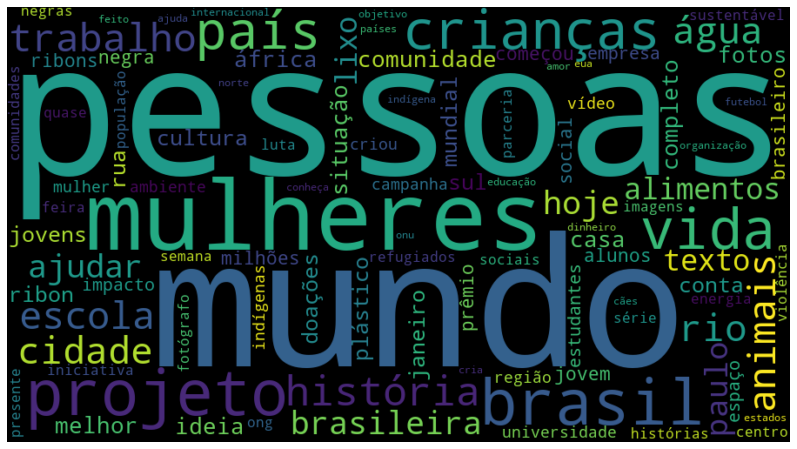

Label:  ECOLOGIA
lixo           44
plástico       42
água           41
energia        26
mundo          23
sustentável    21
projeto        19
feita          16
empresa        16
árvores        15
garrafas       15
brasil         15
pessoas        14
ambiente       14
ideia          14
solar          13
amazônia       13
casa           12
cidade         12
feito          12
toneladas      11
rio            11
plásticas      11
processo       11
embalagens     10
dtype: int64


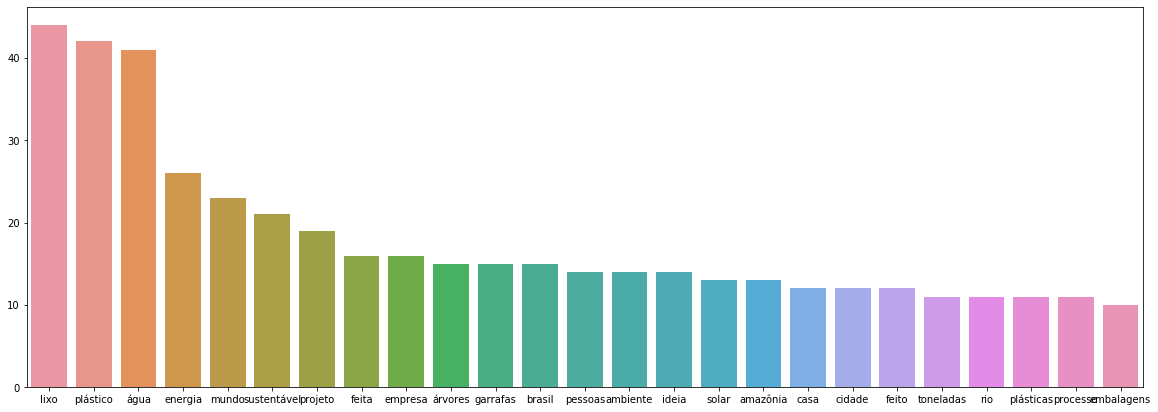

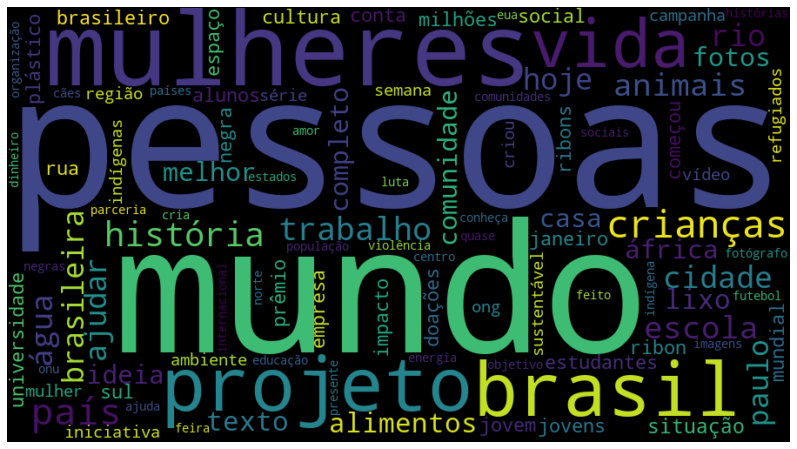

Label:  SOLIDARIEDADE
pessoas        51
ajudar         26
projeto        25
alimentos      24
crianças       19
refugiados     19
rua            19
vida           18
situação       17
mundo          17
brumadinho     13
rio            13
mulheres       13
brasil         13
comida         12
país           12
comprar        12
ajuda          11
vídeo          10
eua            10
ong            10
moradores       9
homem           9
voluntários     9
campanha        9
dtype: int64


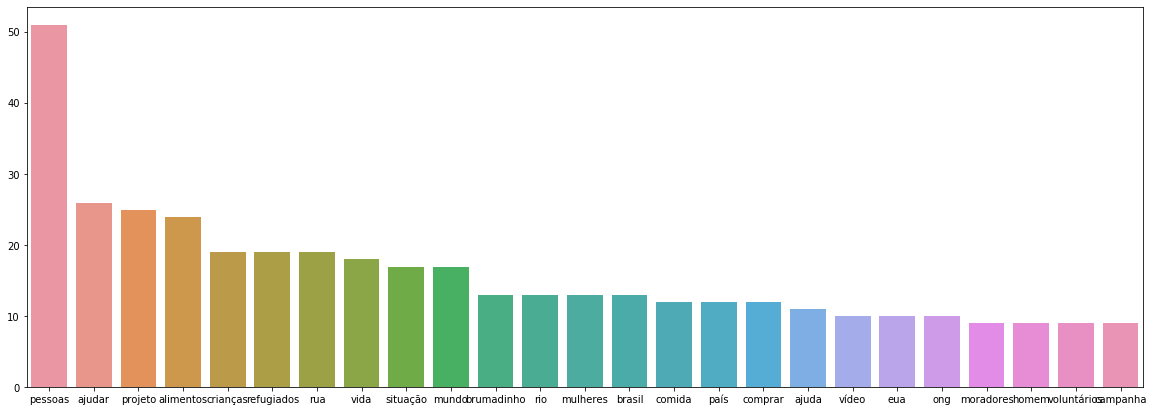

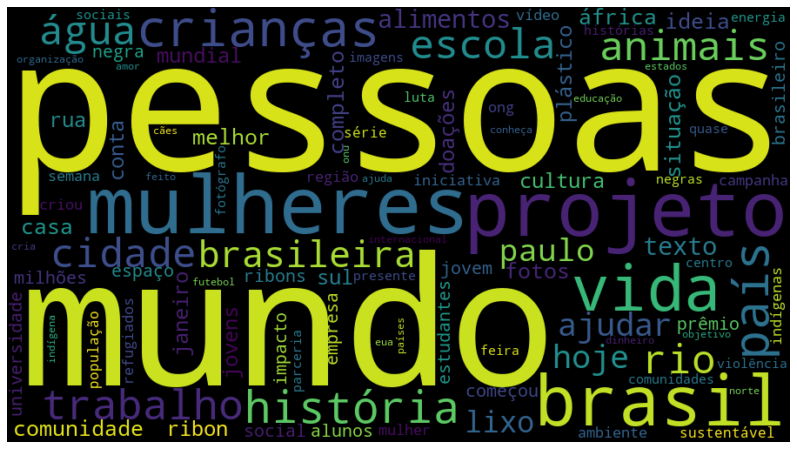

In [91]:
target_labels = df_data[TARGET_VARIABLE].unique()

for label in target_labels:
    words_for_label = df_data[df_data[TARGET_VARIABLE] == label]
    print("Label: ", label)
    print(generate_freq_dist_plot(words_for_label['PROCESSED_DOC']))
    generate_wordcloud(df_data['PROCESSED_DOC'])

### Storing partial progress

In [92]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_processed_data.xlsx"

In [93]:
df_data.to_excel(excel_filename)

 ## Text Parser(Counting and vectorizing)
 Now we have clear tokens we can measure how much they affect the outcome prediction and how many of them exist in each sample.

In [94]:
"""  We then load the data for stability """
df_processed_data = pd.read_excel(excel_filename, index_col=0)
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 53 to 228
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   LABEL_TRAIN           1679 non-null   object
 1   TEXT_VARIABLE         1679 non-null   object
 2   PREPROCESSED_TEXT     1679 non-null   object
 3   RAW_DOC               1679 non-null   object
 4   NORMALIZED_DOC        1679 non-null   object
 5   LEMMATIZED_DOC        1679 non-null   object
 6   ENTITIES              927 non-null    object
 7   PROCESSED_DOC         1679 non-null   object
 8   SEMANTICS             1679 non-null   object
 9   UNWANTED_POS          677 non-null    object
 10  PROCESSED_DOC_TOKENS  1679 non-null   object
dtypes: object(11)
memory usage: 157.4+ KB
None


### Dealing with missing values
As there are some samples without content, they'll not be useful to train or to validate the model. 
Hapilly they're not many so let's drop them.

In [95]:
missing_variables = ['ENTITIES', 'UNWANTED_POS']
df_processed_data = df_processed_data.drop(columns=missing_variables).dropna()
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 53 to 228
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   LABEL_TRAIN           1679 non-null   object
 1   TEXT_VARIABLE         1679 non-null   object
 2   PREPROCESSED_TEXT     1679 non-null   object
 3   RAW_DOC               1679 non-null   object
 4   NORMALIZED_DOC        1679 non-null   object
 5   LEMMATIZED_DOC        1679 non-null   object
 6   PROCESSED_DOC         1679 non-null   object
 7   SEMANTICS             1679 non-null   object
 8   PROCESSED_DOC_TOKENS  1679 non-null   object
dtypes: object(9)
memory usage: 131.2+ KB
None


### Choosing best parameters for Counting and Vectorizing

In [32]:
is_gridsearching = False
if is_gridsearching:
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score

    search_count_vectorizer = CountVectorizer()
    search_tfidf_transformer = TfidfTransformer()
    clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

    search_params = {
        'vect__min_df': np.arange(0, 0.001, 0.0003),
        'vect__max_df': np.arange(0.2, 0.9, 0.3),
        'vect__max_features': [None],
        'vect__ngram_range': [(1, 2), (1, 3), (2, 3)],
        'tfidf__norm': ['l2'],
        'tfidf__use_idf': [False, True],
        'tfidf__smooth_idf': [False],
        'tfidf__sublinear_tf' : [False, True]}

    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('clf', clf)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(df_data['PROCESSED_DOC'].values, df_data[TARGET_VARIABLE])
    results = gs.cv_results_
    print(gs.best_params_)

In [34]:
''' Best parameter using GridSearch (CV score=0.535):
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True,
'vect__max_df': 0.6000000000000001, 'vect__max_features': None, 'vect__min_df': 0.0007,
'vect__ngram_range': (1, 2)}
'''
''' Text Parser
    This part is responsible to give weights to important tokens and remove
    weight for unwanted ones or those who can be misguiding.
    - Frequency Counter
    - Id-IdF Counter
'''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)

''' Let's transform the lemmatized documents into count vectors '''
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

print(count_vectors[0])
print(frequency_vectors[0])

  (0, 834)	1
  (0, 3081)	1
  (0, 3624)	1
  (0, 4158)	1
  (0, 4713)	1
  (0, 4713)	0.2357575544403921
  (0, 4158)	0.2027071309672316
  (0, 3624)	0.17048523211663633
  (0, 3081)	0.2195004817895796
  (0, 834)	0.17154960068616043


In [35]:
''' Let's transform the lemmatized documents into count vectors '''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

mutual_info_vector = mutual_info_classif(count_vectors, df_processed_data[TARGET_VARIABLE]) 
print(mutual_info_vector)

[0.00999257 0.00294594 0.00277418 ... 0.0039515  0.0039515  0.00249319]


In [36]:
print(count_vectorizer.get_feature_names())

['abaixo', 'abaixo ler', 'abaixo média', 'abandonada', 'abandonadas', 'abandonado', 'abandonados', 'abastecer', 'abastecimento', 'abc', 'abcdelas', 'abelhas', 'aberta', 'aberto', 'abertura', 'abl', 'abolir', 'abolir rituais', 'abolição', 'abra', 'abraçou', 'abre', 'abrem', 'abria', 'abriga', 'abrigar', 'abrigo', 'abrigos', 'abril', 'abrindo', 'abrindo debate', 'abrir', 'abrir portas', 'abriram', 'abriria', 'abriu', 'absoluta', 'absolutamente', 'absoluto', 'absorvente', 'absorvente sustentável', 'absorventes', 'abstratas', 'abu', 'abundante', 'abundância', 'acaba', 'acaba eleger', 'acaba lançar', 'acabado', 'acabam', 'acabam lançar', 'acabar', 'acabar fome', 'acabou', 'academia', 'acadêmicos', 'acalmar', 'acarajé', 'acaso', 'aceleradora', 'acelerar', 'acervo', 'acessar', 'acessar tela', 'acesse', 'acesse texto', 'acessibilidade', 'acesso', 'acesso projetos', 'acesso água', 'acessíveis', 'acessíveis pessoas', 'acessível', 'acha', 'achamos', 'achar', 'achava', 'achem', 'acho', 'achou', 'a

## Topic Modelling
One way to approach this problem is to search for unsupervisionised patterns inside data to form topics and then use those topics to classify.

### Trying LDA model

In [163]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

number_topics = 30
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
topics_vectors = lda.fit_transform(count_vectors)
# Print the topics found by the LDA model
print("Topics found via LDA:")

words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(LDA.components_):
    print("\nTopic #%d:" % topic_idx)
    print(" ".join([words[i]
                    for i in topic.argsort()[:-number_words - 1:-1]]))

Topics found via LDA:

Topic #0:
escola escolas alunos projeto educação professora presente pública água negra

Topic #1:
projeto mulheres crianças mundo festival filho ensina social cultura impacto

Topic #2:
vida mulheres água energia projeto mundo pessoas cachorros história natureza

Topic #3:
pessoas trabalho centro brasil crianças mulheres ajudar público animais parceria

Topic #4:
ribon mulheres ribons escola pessoas doações ajude amigos impacto vidas

Topic #5:
mundo crianças mulheres fotos história pessoas melhor presente animais eua

Topic #6:
mundo algodão ajuda brasil produção vida história melhor brasileira mulheres

Topic #7:
inglaterra rede imagens medalhas praias olímpica documentário banco diferente vasos

Topic #8:
mundo pessoas brasil fotografia mulheres situação alunos carnaval escola países

Topic #9:
mulheres projeto violência visa botão pessoas abaixo dinheiro toque botão toque

Topic #10:
alimentos desperdício pessoas projeto ambiente mundo animais vida comunidad

### Storing topics scores as variables

In [167]:
df_vectors = pd.DataFrame(topics_vectors)
print(df_vectors.info())

[0.22544269 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556
 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556
 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556
 0.00555556 0.00555556 0.61900176 0.00555556 0.00555556 0.00555556
 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1679 non-null   float64
 1   1       1679 non-null   float64
 2   2       1679 non-null   float64
 3   3       1679 non-null   float64
 4   4       1679 non-null   float64
 5   5       1679 non-null   float64
 6   6       1679 non-null   float64
 7   7       1679 non-null   float64
 8   8       1679 non-null   float64
 9   9       1679 non-null   float64
 10  10      1679 non-null   float64
 11  11      1679 non-null   float64
 12  12      1679 non-null   float64
 1

In [174]:
mutual_info_vector = mutual_info_classif(df_vectors, df_processed_data[TARGET_VARIABLE]) 
print(mutual_info_vector)

[0.02264964 0.02215195 0.04568289 0.04908294 0.02582009 0.03168524
 0.03148649 0.02437965 0.0450384  0.05285898 0.0513992  0.05561458
 0.03797457 0.03701355 0.03964634 0.02464201 0.0321294  0.04927171
 0.02822389 0.06606555 0.0357081  0.01907602 0.05838356 0.01702675
 0.03765303 0.05456878 0.04574506 0.04768932 0.04800021 0.04044345]


## Trying gensim lda model

In [169]:
''' First let's create a dicitionary for the topics '''
dictionary = gensim.corpora.Dictionary(processed_doc_tokens)

''' Then let's remove some extreme examples '''
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

''' Then create a bow corpus using those tokens '''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_doc_tokens]

''' Then we can use this bow corpus to generate a frenquecy corpus '''
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

''' We can use those frequencies to generate topics '''
NUM_TOPICS = 30
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, workers=4)
corpus_topics = lda_model_tfidf[corpus_tfidf]

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.033*"pai" + 0.025*"comunidades" + 0.021*"" + 0.020*"voz" + 0.020*"maranhão" + 0.019*"filho" + 0.019*"presidente" + 0.019*"mulheres" + 0.018*"novidade" + 0.017*"mão"
Topic: 1 Word: 0.053*"cria" + 0.038*"alunos" + 0.035*"crianças" + 0.034*"sustentável" + 0.032*"fotos" + 0.029*"ganha" + 0.023*"" + 0.020*"cultural" + 0.019*"brasil" + 0.019*"milhões"
Topic: 2 Word: 0.033*"onu" + 0.027*"jovens" + 0.025*"google" + 0.023*"lixo" + 0.022*"homenagem" + 0.022*"" + 0.021*"brasileira" + 0.015*"app" + 0.014*"água" + 0.014*"modelo"
Topic: 3 Word: 0.030*"" + 0.028*"vida" + 0.021*"indígena" + 0.021*"carnaval" + 0.020*"áfrica" + 0.016*"saúde" + 0.016*"estados" + 0.015*"unidos" + 0.014*"campanha" + 0.014*"natureza"
Topic: 4 Word: 0.039*"projeto" + 0.029*"país" + 0.025*"melhor" + 0.025*"milhão" + 0.022*"presente" + 0.021*"brasileiros" + 0.021*"situação" + 0.021*"lixo" + 0.020*"movimento" + 0.019*"africana"
Topic: 5 Word: 0.030*"famílias" + 0.029*"horas" + 0.028*"vida" + 0.024*"menino" + 0.

### Storing topics scores as variables

In [170]:
''' We'll need the same number of lists as the number of topics  '''
topics_scores = [[] for i in range(NUM_TOPICS)]

''' We then extract each row score to different columns '''
for doc_topics in corpus_topics:
    dict_topics = dict(doc_topics)
    for i in range(0, NUM_TOPICS):
        if i in dict_topics:
            topics_scores[i].append(dict_topics[i])
        else:
            topics_scores[i].append(0)

''' And store then in the data as variables for their respectives rows'''
for i in range(0, NUM_TOPICS):
    column_name = 'TOPIC_' + str(i)
    topics_columns.append(column_name)
    df_data[column_name] = topics_scores[i]

print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 53 to 228
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LABEL_TRAIN           1679 non-null   object 
 1   TEXT_VARIABLE         1679 non-null   object 
 2   PREPROCESSED_TEXT     1679 non-null   object 
 3   RAW_DOC               1679 non-null   object 
 4   NORMALIZED_DOC        1679 non-null   object 
 5   LEMMATIZED_DOC        1679 non-null   object 
 6   ENTITIES              1679 non-null   object 
 7   PROCESSED_DOC         1679 non-null   object 
 8   SEMANTICS             1679 non-null   object 
 9   UNWANTED_POS          1679 non-null   object 
 10  PROCESSED_DOC_TOKENS  1679 non-null   object 
 11  TOPIC_0               1679 non-null   float64
 12  TOPIC_1               1679 non-null   float64
 13  TOPIC_2               1679 non-null   float64
 14  TOPIC_3               1679 non-null   float64
 15  TOPIC_4              

In [171]:
mutual_info_vector = mutual_info_classif(df_data[topics_columns], df_processed_data[TARGET_VARIABLE]) 
print(mutual_info_vector)

[0.05132012 0.03224432 0.05454269 0.05588073 0.06080452 0.06877501
 0.10939807 0.07170943 0.04600332 0.06851073 0.0612889  0.05679791
 0.0589056  0.11818324 0.06720886 0.0429593  0.06174193 0.05527315
 0.06917242 0.07198687 0.04738599 0.05280667 0.05669349 0.06764437
 0.05169901 0.05848565 0.07139281 0.05886941 0.0441584  0.0629664
 0.0848529  0.0479989  0.12562011 0.07448967 0.0472764  0.05624491
 0.03265685 0.03453884 0.04577618 0.05639755 0.06194511 0.0508992
 0.06456304 0.05819873 0.06855457 0.03922338 0.05849611 0.04520341
 0.04485236 0.08906941 0.0798416  0.07564973 0.03905444 0.0524975
 0.06196077 0.0441992  0.07372025 0.12627836 0.05351143 0.0638385
 0.05182655 0.04022353 0.05714041 0.02602975 0.06409741 0.06487822
 0.0725999  0.06672499 0.07234467 0.0652192  0.07705001 0.06874986
 0.0640349  0.04837399 0.09637516 0.04955491 0.09782545 0.05724411]


### Model Train and Cross-Validation

In [172]:
gnb = GaussianNB()

pipeline_simple = Pipeline([
    ('gnb', gnb)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    df_vectors,
    df_data[TARGET_VARIABLE], cv=5)
print("Mean accuracy for explicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.05597903340440654


In [173]:
gnb = GaussianNB()

pipeline_simple = Pipeline([
    ('gnb', gnb)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    df_data[topics_columns],
    df_data[TARGET_VARIABLE], cv=5)
print("Mean accuracy for explicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.10959843638948116


In [120]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

''' Explicitly using components '''
pipeline_simple = Pipeline([
    ('clf', clf)
])

count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for explicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.7295979469632164


In [56]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

scores = cross_val_score(
    pipeline,
    df_processed_data['PROCESSED_DOC'],
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for implicit pipeline: ", scores.mean())

Mean accuracy for implicit pipeline:  0.6183418876532649


### Evaluating the best model

In [41]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE].to_list(),
    test_size=0.33, random_state=42)

''' First we need to instantiate some components again to avoid overfit'''
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

pipeline_simple = Pipeline([
    ('clf', clf)
])

train1 = X_train
labelsTrain1 = y_train
test1 = X_test
labelsTest1 = y_test
"""  train """
pipeline_simple.fit(train1, labelsTrain1)
"""  test """
preds = pipeline_simple.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=df_processed_data[TARGET_VARIABLE].unique()))

accuracy: 0.6389891696750902
                  precision    recall  f1-score   support

      CELEBRACAO       0.82      0.77      0.79        47
       PROPOSITO       0.40      0.42      0.41        33
         CULTURA       0.82      0.50      0.62        18
         ANIMAIS       0.58      0.60      0.59        63
         ESPORTE       0.57      0.72      0.64        43
          ETNIAS       0.59      0.72      0.65        61
         CIENCIA       0.74      0.65      0.70        49
           SAUDE       0.73      0.48      0.58        23
EMPREENDEDORISMO       0.78      0.69      0.73        26
     DIVERSIDADE       0.39      0.68      0.49        31
        EDUCACAO       0.88      0.65      0.74        54
    SCARCE_GROUP       0.75      0.43      0.55        14
        ECOLOGIA       0.74      0.49      0.59        35
   SOLIDARIEDADE       0.67      0.74      0.70        57

        accuracy                           0.64       554
       macro avg       0.68      0.61    

### Better visualising model classification

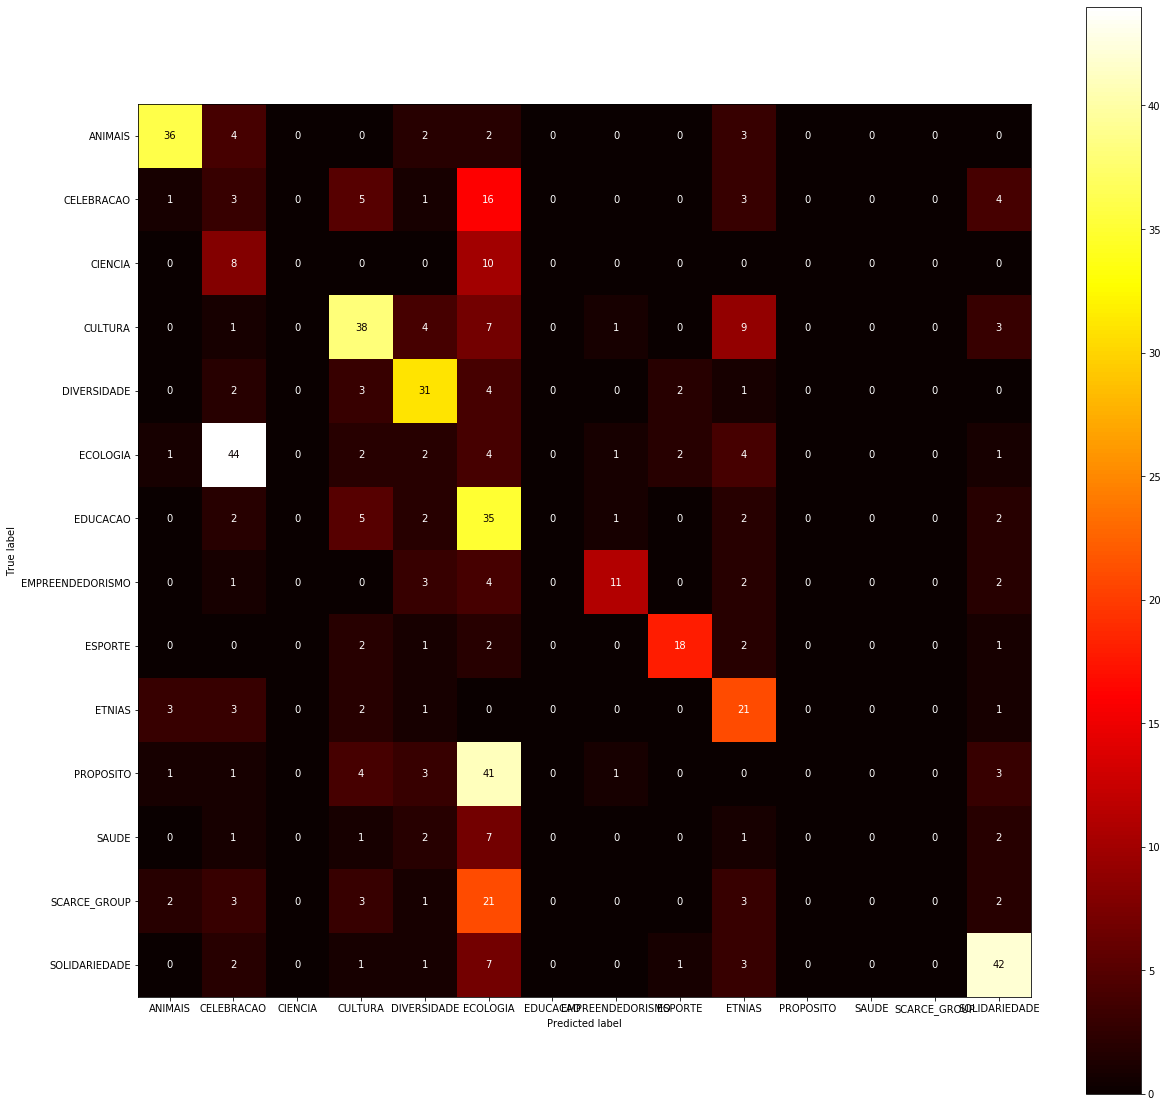

In [42]:
fig = plt.figure(figsize=(20, 20))
axes = plt.axes()

print(plot_confusion_matrix(pipeline, preds, labelsTest1, cmap='hot', ax=axes))